***
*Project:* Helmholtz Machine on Niche Construction

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Experiment 6</span> 

# Active Sampling on Excluding False Positive


*Updated:* Feb 10, 2024


<img src="Helmzz.jpg" style="width:550px">
<caption><center> **Figure 1**: The Helmholtz Machine  </center></caption>


In [470]:
import numpy as np
import matplotlib.pyplot as plt

In [471]:
def sigmoid(x):
    y = 1/(1+np.exp(-x))
    return y

In [472]:
def one_step_para_init(n_dz_slice,init_type):
    """
    Arguments:
    n_dz_slice -- 2 columns of n_dz
    init_type -- "zero" or "random", "zero" assigns 0 to all parameters, "random" samples from standard Gaussian

    Returns:
    Phi, Theta -- -1 column bias
    """
    l = np.where(n_dz_slice[:,0] != 0)[0].size  # number of layers
    layer_vt = np.append(n_dz_slice[:l,0],n_dz_slice[0,1])
    Phi = {}
    Theta = {}
    for i in range(l):
        if init_type == "zero":
            Phi["Phi_" + str(i) + str(i+1)] = np.zeros((layer_vt[i+1],layer_vt[i]+1))
            Theta["Theta_" + str(l-i) + str(l-i-1)] = np.zeros((layer_vt[l-i-1],layer_vt[l-i]+1))
        elif init_type == "random":
            Phi["Phi_" + str(i) + str(i+1)] = np.random.randn(layer_vt[i+1],layer_vt[i]+1)
            Theta["Theta_" + str(l-i) + str(l-i-1)] = np.random.randn(layer_vt[l-i-1],layer_vt[l-i]+1)
        else:
            raise Exception("Wrong Init Type")
        Phi["Phi_" + str(i) + str(i+1)][:,-1] = 0          #bias
        Theta["Theta_" + str(l-i) + str(l-i-1)][:,-1] = 0
    return Phi,Theta

In [473]:
def one_step_forward(x,activation_type,parameter_set):
    """
    Arguments:
    x -- input instantiation layer, numpy array of shape (n,1)
    activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
    parameter_set -- parameters from x to y. Python dictionary of length l. The keys are ordered sequentially from layer x to y.
    
    Returns:
    G -- activation of each layer including x
    q -- probability of layer y
    """
    l = len(parameter_set)
    p_keys = [*parameter_set]
    G = {'z0': x}
    g = x
    
    for i in range(l):
        phi = parameter_set[p_keys[i]]
        pre_ac = np.matmul(phi,np.append(g,[[1]], axis=0))  # pre-activation
        if activation_type == "sigmoid":
            g = sigmoid(pre_ac)
        elif activation_type == "tanh":
            g = np.tanh(pre_ac)
        if i == l-1:
            g = sigmoid(pre_ac)
        G['z'+str(i+1)] = g
    return G,g

In [474]:
def one_step_forward_batch(X,activation_type,parameter_set,norm_par):
    """
    Arguments:
    X -- input instantiation layer, numpy array of shape (n_x,n_sample)
    activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
    parameter_set -- parameters from x to y. Python dictionary of length l. The keys are ordered sequentially from layer x to y.
    norm_par -- normalize parameters to mean 0, variance 1
    
    Returns:
    G -- activation of each layer including x
    q -- probability of layer y
    """
    l = len(parameter_set)
    p_keys = [*parameter_set]
    G = {'z0': X}
    g = X
    n_sample = X.shape[1]
    
    for i in range(l):
        phi = parameter_set[p_keys[i]]
        pre_ac = np.matmul(phi,np.append(g,np.ones((1,n_sample)), axis=0))  # pre-activation
        if activation_type == "sigmoid":
            g = sigmoid(pre_ac)
        elif activation_type == "tanh":
            g = np.tanh(pre_ac)
        if i == l-1:
            g = sigmoid(pre_ac)
        G['z'+str(i+1)] = g
        
        if norm_par == True and X.shape[0] > 1:
            mean = pre_ac.mean(axis=1,keepdims=True)
            variance = ((pre_ac-mean)**2).mean(axis=1,keepdims=True)
            print("mean",mean)
            print("variance",variance)
            parameter_set[p_keys[i]][:,:-1] /= np.sqrt(variance)
            parameter_set[p_keys[i]][:,-1:] = (phi[:,-1:] - mean)/np.sqrt(variance)
    return G,g

In [475]:
def one_step_update(x,y,G,activation_type,parameter_set,value_set,lr,\
                    fz_binary,fz_bias,layer_norm,layer_norm_rate,check_lr):
    """
    Arguments:
    x -- input sampling layer, numpy array of shape (n,1)
    y -- target sampling layer, numpy array of shape (m,1)
    G -- output of one_step_forward_norm, activation of each layer including x
    activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
    parameter_set -- parameters from x to y. Each array phi: -2 column bias, -1 column scale
    value_set -- list or array [[a_x,b_x],[a_y,b_y]], where a is the positive outcome and b is the negative outcome of a Bernoulli experiment
    lr -- learning rate, decimals
    fz_binary -- True or Flase. If True, [a_x,b_x] are fixed values; if False, update [a_x,b_x]
    fz_bias -- True or Flase. If True, last column of phi is fixed; if False, update bias
    fz_W -- True or Flase. If True, freeze weights; if False, update weights
    layer_norm -- True or Flase, whether to adjust row distribution of W (more evenly distributed) by adjusting the 
    updating rate "layer_norm_rate" of dW
    check_lr -- True or Flase. If True, check current lr and update it as needed
    
    Returns:
    x_values -- updated sampling values of input layer
    parameter_set -- updated parameters
    loss -- value of loss function before updating, a number
    grad_set -- gradients of parameters
    lr -- updated learning rate
    """
    
    a_x = value_set[0,0]
    b_x = value_set[0,1]
    a_y = value_set[1,0]
    b_y = value_set[1,1]
    l = len(parameter_set)
    p_keys = [*parameter_set]
    grad_set = {}
    
    # derivatives
    q = G['z'+str(l)]
    u = q - (y-b_y)/(a_y-b_y)   #[n_y,1]
    loss = np.array(-np.sum(((y-b_y)*np.ma.log(q) + (a_y-y)*np.ma.log(1-q))/(a_y-b_y)))  # layer entropy loss
    
    if np.where(np.abs(y - a_y) < 1e-8)[0].size + np.where(np.abs(y - b_y) < 1e-8)[0].size != y.size:
        raise Exception("Incorrect output layer" + str(a_y)+ " "+str(b_y)+ " "+str(y))

    for i in range(l-1,-1,-1):
        phi = parameter_set[p_keys[i]]
        grad_set['d_'+p_keys[i]] = np.zeros(phi.shape)
        W = phi[:,:-1]        #[n_y,n_z]
        bias = phi[:,-1:]   #[n_y,1]
        z = G['z'+str(i)]      #[n_z,1]
        
        dW = np.outer(u,z)     #[n_y,n_z]
        grad_set['d_'+p_keys[i]][:,:-1] = dW
        # update weights
        if layer_norm == True:
            dW = layer_lr(W, dW, rate=layer_norm_rate)
        parameter_set[p_keys[i]][:,:-1] -= lr * dW
        
        if fz_bias == False:
            d_bias = u             #[n_y,1]
            parameter_set[p_keys[i]][:,-1:] -= lr * d_bias
            grad_set['d_'+p_keys[i]][:,-1:] = d_bias
        
        dz = np.matmul(W.T,u)  #[n_z,1]
        if i > 0:
            if activation_type == "sigmoid":
                u = dz * z * (1-z)
            elif activation_type == "tanh":
                u = dz * (1-z**2)
        else:
            # input layer, parameters a_x, b_x
            if fz_binary == False:
                d_ax = np.mean(dz[np.where(np.abs(x - a_x) < 1e-8)[0]]) if np.where(np.abs(x - a_x) < 1e-8)[0].size>0 else 0 # use mean instead of sum
                d_bx = np.mean(dz[np.where(np.abs(x - b_x) < 1e-8)[0]]) if np.where(np.abs(x - b_x) < 1e-8)[0].size>0 else 0
                if np.where(np.abs(x - a_x) < 1e-8)[0].size + np.where(np.abs(x - b_x) < 1e-8)[0].size != dz.size:
                    raise Exception("Incorrect input layer" + str(a_x)+ " "+str(b_x)+ " "+str(x))
                a_x -= lr * np.clip(d_ax,-0.1,0.1)
                b_x -= lr * np.clip(d_bx,-0.1,0.1)
            x_values = [a_x,b_x]
    
    if check_lr == True:
        G,q = one_step_forward(x,activation_type,parameter_set)
        loss_new = np.array(-np.sum(((y-b_y)*np.ma.log(q) + (a_y-y)*np.ma.log(1-q))/(a_y-b_y)))  # layer entropy loss
        delta_loss = loss - loss_new
        delta_f = 0
        for keys in grad_set:
            delta_f += np.sum(grad_set[keys]**2)
        delta_f *= lr
        print("delta_loss: "+ str(delta_loss), "delta_f: "+ str(delta_f))
        if delta_loss < delta_f:
            lr /= delta_f/delta_loss
            print("learning rate change: " + str(lr))
    
    return x_values,lr,loss,grad_set

In [476]:
def layer_lr(W, dW, rate):
    """
    adjust row distribution of W (more evenly distributed) by adjusting the updating rate of dW
    Arguments:
    W -- phi[:,:-1], numpy array of sahpe (n_z,n_x)
    dW -- derivatives of W
    rate -- 10 folds, x rate; 100 folds, x 2 rate
    
    Returns:
    dW -- updated gradient
    """
    multiple = np.log10(np.abs(W)/np.min(np.abs(W),axis=1,keepdims=True)).astype(int)
    index = np.where(multiple > 0) #& (W*dW > 0))
    dW[index] *= rate
    return dW

In [477]:
def one_step_prob_matrix(x_dist,activation_type,n_x,parameter_set):
    """
    Arguments:
    x_dist -- probability distribution of input x, numpy array of shape (n_x, )
    
    Returns:
    prob_ft -- probability matrix of x to neurons in y layer, numpy array of shape (2**n_x+1, n_y+1)
    prob_cat -- probability matrix of x to categories of y, numpy array of shape (2**n_x+1, 2**n_y+1)
    last row is unconditioned probability p(y), last column is entropy H(Y|x), H(Y|X)
    """
    if n_x == 1:
        x_ind = np.array([1])
    else:
        x_ind = np.arange(2**n_x)
    
    X = binarilize(x_ind,n_x)  #(n_x,2**n_x)
    G,q = one_step_forward_batch(X,activation_type,parameter_set,norm_par=False)
    
    n_y = q.shape[0]           # q:(n_y,2**n_x)
    prob_ft = np.zeros((x_ind.size+1,n_y+1))
    for i in range(x_ind.size):
        prob_ft[:-1,:-1] = q.T
    prob_ft[:-1,-1] = entropy_bernoulli(q.T).sum(axis=1)    
    prob_ft[-1,:] = np.matmul(x_dist.reshape(1,-1),prob_ft[:-1,:])
    
    y_ind = np.arange(2**n_y)
    Y = binarilize(y_ind,n_y)  #(n_y,2**n_y)
    prob_cat = np.zeros((x_ind.size+1,2**n_y+1))
    for i in range(x_ind.size):
        prob_cat[i,:-1] = np.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    prob_cat[:-1,-1] = entropy(prob_cat[:-1,:-1])
    prob_cat[-1,:] = np.matmul(x_dist.reshape(1,-1),prob_cat[:-1,:])
    return prob_ft,prob_cat

In [478]:
def entropy(arr):
    """
    row entropy
    """
    if arr.ndim == 1:
        p = arr/arr.sum()
        H = -(p*np.ma.log(p)).sum()
    else:
        p = arr/arr.sum(axis=1,keepdims=True)
        H = -(p*np.ma.log(p)).sum(axis=1)
    H = np.array(H)
    return H

In [479]:
def entropy_bernoulli(p):
    """
    Entropy of multi-variate independent Bernoulli distributions
    Arguments:
    p -- numpy array of bernoulli probabilities p(x=1)
    Returns:
    entropy_b -- entropy of each variable, same shape as p
    """
    entropy_b = -(p*np.ma.log(p) + (1-p)*np.ma.log(1-p))
    entropy_b = np.array(entropy_b)
    return entropy_b

In [480]:
def decimalize(bnr):
    """
    Arguments: bnr -- numpy array of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger array in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = np.zeros(n,dtype=int)
    for i in range(n):
        binary = ''.join(bnr[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [481]:
def binarilize(dcm,width):
    """
    Arguments: dcm -- a decimalized intger array in range [0,2**width), shape (n,)
    Returns:   bnr -- numpy array of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    return bnr

In [482]:
def entropy_itr(H_prev,s,a):
    """
    Iterative formula for entropy:
    H_+1 = (s(H-log(s)) + (s+1)log(s+1) + [alog(a) - (a+1)log(a+1)])/(s+1)
    
    Arguments:
    H_prev -- previous entropy
    s -- total counts
    a -- counts for the category being modified
     
    Returns:
    H -- updated entropy
    """
    H = (s*(H_prev-np.ma.log(s)) + (s+1)*np.log(s+1) + [a*np.ma.log(a) - (a+1)*np.log(a+1)])/(s+1)
    H = np.array(H)
    return H

In [483]:
def init_base(Prob_ft_wake,Prob_cat_wake,base=100):
    """
    Arguments:
    Prob_ft_wake, Prob_cat_wake -- Probability matrices sets of the Helmholtz machine class
    base -- fundamental counts for starting mutual information searching, default 100
    
    Returns:
    Count_ft -- initial count array sets, each array of shape (2*n_neuron+1), (probability of each Bernoulli neuron,total counts,independent entropies)
    Count_cat -- initial count array sets, each array of shape (2**n_neuron+2), (probability of each category,total counts,entropy)
    """
    Count_ft = {}
    Count_cat = {}
    for key in Prob_ft_wake:
        Count_ft[key] = Prob_ft_wake[key][-1,:-1] * base
        Count_ft[key] = np.append(Count_ft[key],base)
        Count_ft[key] = np.append(Count_ft[key],entropy_bernoulli(Prob_ft_wake[key][-1,:-1]))
        
        Count_cat[key] = Prob_cat_wake[key][-1,:-1] * base
        Count_cat[key] = np.append(Count_cat[key],base)
        Count_cat[key] = np.append(Count_cat[key],entropy(Prob_cat_wake[key][-1:,:-1]))
    return Count_ft,Count_cat

In [484]:
def Mutual_inform(q,Count_ft_arr,Count_cat_arr):
    """
    Arguments:
    q -- probability of y from x 
    Count_ft_arr -- total counts of independent neurons in layer y, 
    (probability of each Bernoulli neuron,total counts,entropy of each Bernoulli neuron),of shape (2*n_neuron+1)
    Count_cat_arr -- total counts of categories in layer y, 
    (probability of each category,total counts,entropy), shape (2**n_neuron+2)
    
    Returns:
    sample -- the chosen sample that maximizes current mutual information
    Count_ft_arr,Count_cat_arr -- updated count arrays by +1 at the sampled position
    """
    base = Count_cat_arr[-2]
    n_neuron = q.size
    
    comb = binarilize(np.arange(2**n_neuron),n_neuron)
    count_q = q * base
    q_comb = count_q**comb * (base-count_q)**(1-comb)
    entropy_q = entropy_bernoulli(q) #(n_neuron,1)
    new_entropy_q = entropy_itr(entropy_q,base,q_comb)[0]  #(n_neuron,2**n_neuron)
    
    count_ft = Count_ft_arr[:n_neuron].reshape(-1,1)
    ft_comb = count_ft**comb * (base-count_ft)**(1-comb)
    entropy_ft = Count_ft_arr[-n_neuron:].reshape(-1,1) #(n_neuron,1)
    new_entropy_ft = entropy_itr(entropy_ft,base,ft_comb)[0] #(n_neuron,2**n_neuron)
    
    count_cat = Count_cat_arr[:-2]
    entropy_cat = Count_cat_arr[-1]
    new_entropy_cat = entropy_itr(entropy_cat,base,count_cat)[0] #(2**n_neuron,)
    
    MI = (new_entropy_ft.sum(axis=0) + new_entropy_cat)/2 - new_entropy_q.sum(axis=0) #(2**n_neuron,)
#     MI = new_entropy_cat - new_entropy_q.sum(axis=0) #(2**n_neuron,)
#     choice = MI.argmax()
#     print(MI)
    arr = np.exp((MI-np.min(MI))*800)
    choice = np.random.choice(np.arange(MI.size),p=arr/arr.sum())

    # update count matrices
    Count_ft_arr[:n_neuron] += comb[:,choice]
    Count_ft_arr[n_neuron] += 1
    Count_ft_arr[-n_neuron:] = new_entropy_ft[:,choice]
    
    Count_cat_arr[choice] += 1
    Count_cat_arr[-2] += 1
    Count_cat_arr[-1] = new_entropy_cat[choice]
    
    sample = comb[:,choice:choice+1]
    # return [new_entropy_ft.sum(axis=0),new_entropy_cat,new_entropy_q.sum(axis=0),MI]
    return sample,[new_entropy_ft.sum(axis=0),new_entropy_cat,new_entropy_q.sum(axis=0),MI]

In [485]:
MI = np.array([1,3,0,4])
np.min(MI[MI>0])

1

In [486]:
def update_count(S_bnr,Count_ft_arr,Count_cat_arr):
    """
    Arguments:
    S -- given sample at certain layer, binary values {0,1}, of shape (n_neuron,1)
    Count_ft_arr -- total counts of independent neurons in layer y, 
    (probability of each Bernoulli neuron,total counts,entropy of each Bernoulli neuron),of shape (2*n_neuron+1)
    Count_cat_arr -- total counts of categories in layer y, 
    (probability of each category,total counts,entropy), shape (2**n_neuron+2)
    
    Returns:
    Count_ft_arr,Count_cat_arr -- updated count arrays by +1 at the sampled position
    """
    base = Count_cat_arr[-2]
    n_neuron = S_bnr.size
    
    count_ft = Count_ft_arr[:n_neuron].reshape(-1,1)
    ft_comb = count_ft**S_bnr * (base-count_ft)**(1-S_bnr)
    entropy_ft = Count_ft_arr[-n_neuron:] #(n_neuron,)
    new_entropy_ft = entropy_itr(entropy_ft,base,ft_comb.reshape(-1,)) #(n_neuron,)
#     new_entropy_ft = entropy_itr(entropy_ft,base,S_bnr.reshape(-1,)) #(n_neuron,)
    
    entropy_cat = Count_cat_arr[-1]
    count_cat = Count_cat_arr[decimalize(S_bnr)[0]]
    new_entropy_cat = entropy_itr(entropy_cat,base,count_cat)[0]

    # update count matrices
    Count_ft_arr[:n_neuron] += S_bnr.reshape(-1,)
    Count_ft_arr[n_neuron] += 1
    Count_ft_arr[-n_neuron:] = new_entropy_ft
    
    Count_cat_arr[decimalize(S_bnr)[0]] += 1
    Count_cat_arr[-2] += 1
    Count_cat_arr[-1] = new_entropy_cat

In [487]:
def check_M(Count_ft_arr,Count_cat_arr):
    n_neuron = int((Count_ft_arr.size-1)/2)
    check1 = Count_cat_arr[:-2].sum() - Count_cat_arr[-2] # categorical counts
    check2 = Count_ft_arr[n_neuron] - Count_cat_arr[-2] # total counts of 2 arrays
    check3 = entropy(Count_cat_arr[:-2].reshape(1,-1)) - Count_cat_arr[-1] # categorical entropy
    check4 = (entropy_bernoulli(Count_ft_arr[:n_neuron]/Count_ft_arr[n_neuron]) - Count_ft_arr[-n_neuron:]).mean() # bernoulli entropy
    return [check1,check2,check3,check4]

In [488]:
class Helmholtz_machine:

    def __init__(self, n_dz, activation_type, init_lr = 0.1):
        """
        Arguments:
        n_dz -- number of neurons for each layer, numpy array of shape (n+1,m), where m is the number of instantiation layers, 
        n is the maximum number of inserted layers between adjacent instantiation layers
        activation_type -- we provide 2 choices of activation functions: tanh(x) and sigmoid(x)
        init_lr -- initial learning rate, decimal number
        
        Returns:
        n_layer -- number of instantiation layers
        lr -- different learning rate for each submodule, numpy array of shape (2,m-1)
        """
        self.n_dz = n_dz
        self.n_layer = self.n_dz.shape[1]
        self.n_d = n_dz[0,0]
        self.ac = activation_type
        self.lr = np.ones((2,self.n_layer-1))*init_lr
        
    def parameter_init(self,init_type,value_set):
        """
        Arguments:
        init_type -- "zero" or "random", "zero" assigns 0 to all parameters, "random" samples from standard Gaussian
        value_set -- numpy array [a,b], binary outcomes as {positive, negative}

        Returns:
        Phi, Theta -- -2 column bias, -1 column scale. 
        Eg. {Phi_01:{Phi_01,Phi_12}, Phi_12:{Phi_01,Phi_12,Phi_23}}, dictionary of dictionary
        Scalar -- numpy array of shape (n_layer,2), binary outcomes of every sample layer, shared between wake and sleep phases
        """
        Phi = {}
        Theta = {}
        for i in range(self.n_layer-1):
            Phi["Phi_"+str(i)+str(i+1)],Theta["Theta_"+str(i+1)+str(i)] = one_step_para_init(self.n_dz[:,i:i+2],init_type)
            
        self.Phi = Phi
        self.Theta = Theta
        self.Scalar = np.repeat(value_set.reshape(1,-1),self.n_layer,axis=0)
    
    def set_control(self,Fz_binary,fz_bias=True,layer_norm=False,layer_norm_rate=2):
        """
        Arguments:
        Fz_binary -- Boolean list of size n_layer, with last entry always as True
        Fz_scale -- Boolean list of size n_layer-1, with last entry always as True. 
        If True, last 2 columns of phi are fixed; if False, update adaptive scale and bias
        fz_W -- True or Flase. If True, freeze weights; if False, update weights
        layer_norm -- True or Flase, whether to adjust row distribution of W (more evenly distributed) by adjusting the 
        updating rate "layer_norm_rate" of dW
        """
        self.Fz_binary = Fz_binary
        self.fz_bias = fz_bias
        self.layer_norm = layer_norm
        self.ln_rate = layer_norm_rate
        if np.any(np.array(Fz_binary) == False):
            self.Scalar = self.Scalar.astype(float)
    
    def wake_sample(self,d0):
        """
        Stochastic sample in wake phase
        Arguments:
        d0 -- input pattern in {0,1}, numpy array of shape (n_d, 1)

        Returns:
        Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = 0,...m-1
        """
        a = self.Scalar[0,0]
        b = self.Scalar[0,1]
        S = d0*(a-b)+b  # input layer
        Alpha_Q = {"z0":S}
        for i in range(self.n_layer-2):
            G,q = one_step_forward(S,self.ac,self.Phi["Phi_"+str(i)+str(i+1)])
            a = self.Scalar[i+1,0]
            b = self.Scalar[i+1,1]
            S = ((q > np.random.rand(len(q),1)).astype(int))*(a-b)+b
            Alpha_Q["z"+str(i+1)] = S
        Alpha_Q["z"+str(self.n_layer-1)] = [[1]]
        return Alpha_Q
    
    def sleep_sample(self):
        """
        Stochastic sample in sleep phase
        Returns:
        Alpha_P -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = m-1,...,0
        """
        S = [[1]]
        Alpha_P = {"z"+str(self.n_layer-1):S}
        for i in range(self.n_layer-1,0,-1):
            G,p = one_step_forward(S,self.ac,self.Theta["Theta_"+str(i)+str(i-1)])
            a = self.Scalar[i-1,0]
            b = self.Scalar[i-1,1]
            S = ((p > np.random.rand(len(p),1)).astype(int))*(a-b)+b   # rejection sampling as a or b
            Alpha_P["z"+str(i-1)] = S
        return Alpha_P
    
    def wake_update(self,Alpha_P,check_lr=False):
        """
        Arguments:
        Alpha_P -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = m-1,...,0

        Returns:
        Phi, [a_x,b_x], lr
        Loss -- numpy array of length m-1; the first m-2 values are layer loss, the last term is the total loss
        Grad_set -- gradients of parameters
        """
        Loss = np.zeros(self.n_layer)
        Grad_set = {}
        for i in range(self.n_layer-2):
            x = Alpha_P['z'+str(i)]
            y = Alpha_P['z'+str(i+1)]
            G,q = one_step_forward(x,self.ac,self.Phi["Phi_"+str(i)+str(i+1)])    
            
            self.Scalar[i,:],self.lr[0,i],loss,Grad_set["grad_Phi_"+str(i)+str(i+1)] = one_step_update(x,y,G,self.ac,\
             self.Phi["Phi_"+str(i)+str(i+1)],self.Scalar[[i,i+1],:],self.lr[0,i],\
                self.Fz_binary[i],self.fz_bias,self.layer_norm,self.ln_rate,check_lr)
            Loss[i] = loss
            Loss[-1] += loss
        return Loss,Grad_set
    
    def sleep_update(self,Alpha_Q,check_lr=False):
        """
        Arguments:
        Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = m-1,...,0

        Returns:
        Theta, [a_x,b_x], lr
        Loss -- numpy array of length m-1; the first m-2 values are layer loss, the last term is the total loss
        Grad_set -- gradients of parameters
        """
        Loss = np.zeros(self.n_layer)
        Grad_set = {}
        for i in range(self.n_layer-1,0,-1):
            x = Alpha_Q['z'+str(i)]
            y = Alpha_Q['z'+str(i-1)]
            G,p = one_step_forward(x,self.ac,self.Theta["Theta_"+str(i)+str(i-1)])
            
            self.Scalar[i,:],self.lr[1,i-1],loss,Grad_set["grad_Theta_"+str(i)+str(i-1)] = one_step_update(x,y,G,self.ac,\
                self.Theta["Theta_"+str(i)+str(i-1)],self.Scalar[[i,i-1],:],self.lr[1,i-1],\
                self.Fz_binary[i],self.fz_bias,self.layer_norm,self.ln_rate,check_lr)
            Loss[i-1] = loss
            Loss[-1] += loss
        return Loss,Grad_set
            
    def check_learning_rate(self,Alpha_P,Alpha_Q):
        self.wake_update(Alpha_P,check_lr=True) # see self.lr
        self.sleep_update(Alpha_Q,check_lr=True)
    
    # Compute latent statistics
    def wake_sample_batch(self,D,norm_par=False):
        """
        Arguments:
        D -- data distriution represented in {0,1}, numpy array of shape (n_d, n_data)
        norm_par -- If True, normalize parameters to mean 0, variance 1
        
        Returns:
        Alpha_Q_bnr -- assignment of each neuron as {1,0}, Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], n_data),i = 0,...m-1
        """
        n_data = D.shape[1]
        a = self.Scalar[0,0]
        b = self.Scalar[0,1]
        S = D*(a-b)+b  # input layer
        Alpha_Q_bnr = {"z0":D}
        for i in range(self.n_layer-2):
            G,q = one_step_forward_batch(S,self.ac,self.Phi["Phi_"+str(i)+str(i+1)],norm_par)
            a = self.Scalar[i+1,0]
            b = self.Scalar[i+1,1]
            S_bnr = (q > np.random.rand(len(q),n_data)).astype(int)
            S = S_bnr*(a-b)+b
            Alpha_Q_bnr["z"+str(i+1)] = S_bnr
        return Alpha_Q_bnr
    
    def sleep_sample_batch(self,n_sample,norm_par=False):
        """
        Returns:
        Alpha_P_bnr -- assignment of each neuron (binary value) as {1,0}, Python dictionary of length m with each key-value pair 
        being a numpy array of shape (n_dz[0,i], n_data),i = m-1,...,0
        """
        S = np.ones((1,n_sample))
        Alpha_P_bnr = {"z"+str(self.n_layer-1):S}
        for i in range(self.n_layer-1,0,-1):
            G,p = one_step_forward_batch(S,self.ac,self.Theta["Theta_"+str(i)+str(i-1)],norm_par)
            a = self.Scalar[i-1,0]
            b = self.Scalar[i-1,1]
            S_bnr = (p > np.random.rand(len(p),n_sample)).astype(int)
            S = S_bnr*(a-b)+b   # rejection sampling as a or b
            Alpha_P_bnr["z"+str(i-1)] = S_bnr
        return Alpha_P_bnr
    
    # Compute latent distribution
    def prob_matrix(self,data_dist):
        """
        Compute probability matrices of the Helmholtz machine. For each matrix,
        prob_ft -- probability matrix of x to neurons in y layer, numpy array of shape (2**n_x+1, n_y+1)
        prob_cat -- probability matrix of x to categories of y, numpy array of shape (2**n_x+1, 2**n_y+1)
        last row is unconditioned probability p(y), last column is entropy H(Y|x), H(Y|X)
        """
        self.Prob_ft_wake = {}
        self.Prob_cat_wake = {}
        self.Prob_ft_sleep = {}
        self.Prob_cat_sleep = {}
        dist = data_dist
        for i in range(self.n_layer-2):
            self.Prob_ft_wake["Prob_"+str(i)+str(i+1)],self.Prob_cat_wake["Prob_"+str(i)+str(i+1)] = one_step_prob_matrix(\
                dist,self.ac,self.n_dz[0,i],self.Phi["Phi_"+str(i)+str(i+1)])
            dist = self.Prob_cat_wake["Prob_"+str(i)+str(i+1)][-1,:-1]
        
        dist = np.array([[1]])
        for i in range(self.n_layer-1,0,-1):
            self.Prob_ft_sleep["Prob_"+str(i)+str(i-1)],self.Prob_cat_sleep["Prob_"+str(i)+str(i-1)] = one_step_prob_matrix(\
                dist,self.ac,self.n_dz[0,i],self.Theta["Theta_"+str(i)+str(i-1)])
            dist = self.Prob_cat_sleep["Prob_"+str(i)+str(i-1)][-1,:-1]
            
    def MI_wake(self,d0,Count_ft,Count_cat):
        """
        Sample by maximizing mutual information
        Arguments:
        d0 -- input pattern in {0,1}, numpy array of shape (n_d, 1)
        Count_ft -- initial count array sets, each array of shape (2*n_neuron+1), 
        (probability of each Bernoulli neuron, total counts, independent entropies of each Bernoulli neuron)
        Count_cat -- initial count array sets, each array of shape (2**n_neuron+2), 
        (probability of each category, total counts, entropy)

        Returns:
        Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = 0,...m-1
        Phi, lr; fixed [a_x,b_x]
        Loss -- numpy array of length m-1; the first m-2 values are layer loss, the last term is the total loss
        Grad_set -- gradients of parameters
        """
        a = self.Scalar[0,0]
        b = self.Scalar[0,1]
        S = d0*(a-b)+b  # input layer
        Alpha_Q = {"z0":S}
        keys = [*Count_ft]
        
        Loss = np.zeros(self.n_layer)
        Grad_set = {}
        for i in range(self.n_layer-2):
            G,q = one_step_forward(S,self.ac,self.Phi["Phi_"+str(i)+str(i+1)])
            a = self.Scalar[i+1,0]
            b = self.Scalar[i+1,1]
            S_y = Mutual_inform(q,Count_ft[keys[i]],Count_cat[keys[i]])*(a-b)+b
            
            Fz_binary = [True]*HM.n_layer
            self.Scalar[i,:],self.lr[0,i],loss,Grad_set["grad_Phi_"+str(i)+str(i+1)] = one_step_update(S,S_y,G,self.ac,\
             self.Phi["Phi_"+str(i)+str(i+1)],self.Scalar[[i,i+1],:],self.lr[0,i],\
                Fz_binary,self.fz_bias,self.layer_norm,self.ln_rate,check_lr=False)
            Loss[i-1] = loss
            Loss[-1] += loss
            
            S = S_y
            Alpha_Q["z"+str(i+1)] = S
        Alpha_Q["z"+str(self.n_layer-1)] = [[1]]
        return Alpha_Q,Loss,Grad_set
    
    def MI_wake_sample(self,d0,Count_ft,Count_cat):
        """
        Sample by maximizing mutual information
        Arguments:
        d0 -- input pattern in {0,1}, numpy array of shape (n_d, 1)
        fc -- scale of MI probability

        Returns:
        Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = 0,...m-1
        """
        a = self.Scalar[0,0]
        b = self.Scalar[0,1]
        S = d0*(a-b)+b  # input layer
        Alpha_Q = {"z0":S}
        keys = [*Count_ft]
        vv = {}
        for i in range(self.n_layer-2):
            G,q = one_step_forward(S,self.ac,self.Phi["Phi_"+str(i)+str(i+1)])
            a = self.Scalar[i+1,0]
            b = self.Scalar[i+1,1]
            S,vv[i] = Mutual_inform(q,Count_ft[keys[i]],Count_cat[keys[i]])
            Alpha_Q["z"+str(i+1)] = S*(a-b)+b
        Alpha_Q["z"+str(self.n_layer-1)] = [[1]]
        return Alpha_Q,vv
    
    def wake_sample_count(self,d0,Count_ft,Count_cat):
        """
        Stochastic sample in wake phase and put the sample into counts
        Arguments:
        d0 -- input pattern in {0,1}, numpy array of shape (n_d, 1)

        Returns:
        Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
        a numpy array of shape (n_dz[0,i], 1),i = 0,...m-1
        """
        a = self.Scalar[0,0]
        b = self.Scalar[0,1]
        S = d0*(a-b)+b  # input layer
        Alpha_Q = {"z0":S}
        keys = [*Count_ft]
        for i in range(self.n_layer-2):
            G,q = one_step_forward(S,self.ac,self.Phi["Phi_"+str(i)+str(i+1)])
            a = self.Scalar[i+1,0]
            b = self.Scalar[i+1,1]
            S_bnr = (q > np.random.rand(len(q),1)).astype(int)
            S = S_bnr*(a-b)+b
            Alpha_Q["z"+str(i+1)] = S
            update_count(S_bnr,Count_ft[keys[i]],Count_cat[keys[i]])
            
        Alpha_Q["z"+str(self.n_layer-1)] = [[1]]
        return Alpha_Q,Count_ft,Count_cat

### Initialize model

Based on previous tests, the inserted MLP feature is not stable and requires further investigation. It's embedded in the functions but for experiments, we choose to leave it out and stick to the vanilla sampling-only structure for now.

In [489]:
# structure = [[12,10,8,6,3,1]]
structure = [[12,8,4,1]]
n_dz = np.array(structure)
n_dz

array([[12,  8,  4,  1]])

In [490]:
HM = Helmholtz_machine(n_dz,'sigmoid',init_lr=0.1)

In [491]:
value_set = np.array([1,0])
value_set

array([1, 0])

In [492]:
HM.parameter_init('zero',value_set)

In [493]:
Fz_binary = [True]*HM.n_layer
HM.set_control(Fz_binary,fz_bias=True,layer_norm=False,layer_norm_rate=2)

### Dataset

- Well-formed rule based dataset
- Bayesian mixure of Gaussians dataset
- Self-organization derived dataset
- Instrumental components featured dataset

In [494]:
entire_set = binarilize(np.arange(2**HM.n_d),HM.n_d)
entire_set.shape

(12, 4096)

In [495]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

In [496]:
well_formed_set = well_formed_generate(HM.n_d)
well_formed_set.shape

(12, 905)

In [497]:
# Choose dataset
dataset = well_formed_set

In [498]:
dataset.sum(axis=1)/dataset.shape[1]

array([1.        , 0.65303867, 0.69392265, 0.55359116, 0.57127072,
       0.59337017, 0.60773481, 0.6       , 0.60331492, 0.63314917,
       0.62541436, 0.47845304])

In [499]:
np.unique(dataset,axis=1).shape

(12, 905)

### Train the model

- Train with wake-sleep algorithm
- Train with intersected mutual information maximization algorithm to "orthogonalize" the latent causes thus diversifying the component distributions

In [519]:
epoch = 100
n_data = dataset.shape[1]
n_data

905

In [520]:
# wake-sleep algorithm
for e in range (epoch):
    index = np.random.permutation(n_data)
    Loss_Q_total = np.zeros(HM.n_layer)
    Loss_P_total = np.zeros(HM.n_layer)
    for i in range(n_data):
        d0 = dataset[:,index[i]:index[i]+1]
        Alpha_Q = HM.wake_sample(d0)
        Loss_P,Grad_P = HM.sleep_update(Alpha_Q)
        Alpha_P = HM.sleep_sample()
        Loss_Q,Grad_Q = HM.wake_update(Alpha_P)
        
        Loss_Q_total += Loss_Q
        Loss_P_total += Loss_P
    Loss_Q_total = Loss_Q_total/n_data
    Loss_P_total = Loss_P_total/n_data
    print('Loss_Q: '+ str(np.around(Loss_Q_total,2)), 'Loss_P: '+ str(np.around(Loss_P_total,2)))
# HM.check_learning_rate(Alpha_P,Alpha_Q)

Loss_Q: [1.61 0.09 0.   1.7 ] Loss_P: [4.92 3.78 0.11 8.8 ]
Loss_Q: [1.3  0.08 0.   1.38] Loss_P: [4.86 3.54 0.11 8.52]
Loss_Q: [1.33 0.13 0.   1.46] Loss_P: [5.08 3.46 0.17 8.71]
Loss_Q: [1.54 0.11 0.   1.65] Loss_P: [5.   3.66 0.21 8.88]
Loss_Q: [1.44 0.14 0.   1.58] Loss_P: [4.85 3.73 0.15 8.74]
Loss_Q: [1.58 0.08 0.   1.66] Loss_P: [4.89 3.84 0.12 8.85]
Loss_Q: [1.82 0.14 0.   1.96] Loss_P: [4.82 4.08 0.2  9.1 ]
Loss_Q: [1.65 0.16 0.   1.81] Loss_P: [4.66 4.16 0.15 8.98]
Loss_Q: [1.69 0.1  0.   1.79] Loss_P: [4.99 3.76 0.16 8.91]
Loss_Q: [1.7  0.13 0.   1.83] Loss_P: [4.92 3.84 0.19 8.95]
Loss_Q: [1.58 0.12 0.   1.71] Loss_P: [4.89 3.83 0.16 8.88]
Loss_Q: [1.6  0.14 0.   1.74] Loss_P: [4.85 3.8  0.21 8.86]
Loss_Q: [1.44 0.18 0.   1.61] Loss_P: [4.79 3.68 0.25 8.72]
Loss_Q: [1.44 0.2  0.   1.65] Loss_P: [4.79 3.75 0.27 8.81]
Loss_Q: [1.56 0.17 0.   1.73] Loss_P: [4.81 3.81 0.26 8.88]
Loss_Q: [1.65 0.17 0.   1.82] Loss_P: [4.85 3.86 0.24 8.95]
Loss_Q: [1.56 0.15 0.   1.7 ] Loss_P: [4

In [2445]:
# Alpha_Q_bnr = HM.wake_sample_batch(np.repeat(dataset,10,axis=1),norm_par=True)

In [2446]:
# Alpha_P_bnr = HM.sleep_sample_batch(n_data*10,norm_par=True)

In [ ]:
# HM.Phi

In [ ]:
# HM.Theta

In [1335]:
# Fz_binary = [False,False,False,False,False,True]
# HM.set_control(Fz_binary,fz_bias=True,layer_norm=False,layer_norm_rate=2)

In [2611]:
parameters = {'Phi': HM.Phi, 'Theta': HM.Theta}

In [2612]:
# np.save('parameters_well_formed_12_MI_.npy',parameters)

In [2645]:
# para = np.load('parameters_well_formed_12_MI_success3.npy',allow_pickle=True).item()
# HM.Phi = para['Phi']
# HM.Theta = para['Theta']

### Generation

In [521]:
# data distribution from the dataset
n_data = dataset.shape[1]
data_dcm = decimalize(dataset)
values_d,counts_d = np.unique(data_dcm,return_counts=True)
data_count = np.zeros(2**HM.n_d)
data_count[values_d] = counts_d
data_dist = data_count/n_data
data_dist

array([0.        , 0.        , 0.        , ..., 0.00110497, 0.00110497,
       0.00110497])

In [522]:
HM.prob_matrix(data_dist)

In [523]:
np.where(data_dist!=0)[0].size

905

In [220]:
# HM.Prob_cat_wake

In [221]:
# HM.Prob_cat_sleep

In [524]:
# reorder = np.append(np.where(data_dist!=0)[0],np.where(data_dist==0)[0])
reorder = np.argsort(data_dist)[::-1] # fixed
reorder.size

4096

In [525]:
count = np.where(data_dist!=0)[0].size # fixed
count

905

In [526]:
gen_dist = list(HM.Prob_cat_sleep.values())[-1][-1,:-1]

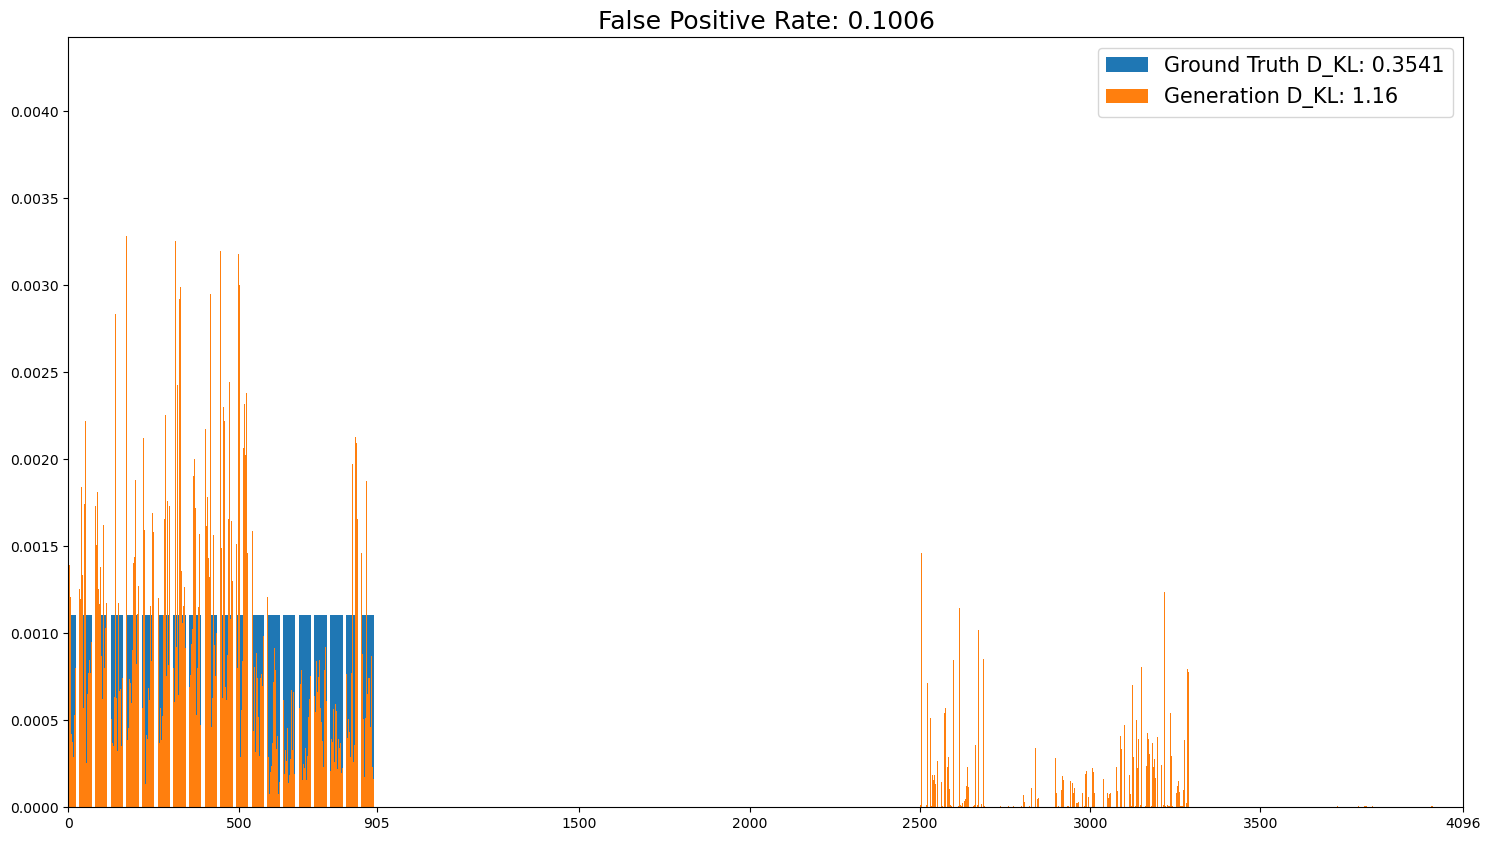

In [527]:
# visualization data distribution (re-order)
x_lim = 2**HM.n_d
n_ticks = 8
xtick = np.arange(0,x_lim,int(x_lim/n_ticks/100+0.5)*100)

xtick[np.argmin(np.abs(xtick - count))] = count
xtick[-1] = x_lim

fig, ax = plt.subplots(figsize=(18, 10))
D_KL_data = np.sum(data_dist*np.log(data_dist+1e-8)-data_dist*np.log(gen_dist+1e-8))    
D_KL_gen = np.sum(gen_dist*np.log(gen_dist+1e-8)-gen_dist*np.log(data_dist+1e-8))
ax.bar(np.arange(x_lim),data_dist[reorder],label = "Ground Truth D_KL: "+str(np.around(D_KL_data,4)))
ax.bar(np.arange(x_lim),gen_dist[reorder],label = "Generation D_KL: "+str(np.around(D_KL_gen,4)))

# ax.bar(np.arange(x_lim),data_dist[reorder],width=0.5,align='edge',label = "Ground Truth")
# ax.bar(np.arange(x_lim)+0.5,generative_dist[reorder],width=0.5,align='edge',label = "Generation")
ax.set(xlim=(0, x_lim), xticks=xtick)
percent = gen_dist[reorder][:count].sum()
ax.set_title("False Positive Rate: "+str(np.around(1-percent,4)),fontsize=18)
plt.legend(fontsize=15)

In [528]:
# statistics
percent = gen_dist[reorder][:count].sum()  # for given dataset
percent

0.8993543915174446

In [529]:
n_well_formed = well_formed_set.shape[1]
n_well_formed

905

In [531]:
gen_count = (gen_dist*n_well_formed*150 + 0.5).astype(int)
gen_count

array([ 0,  0,  0, ..., 59, 40, 50])

In [532]:
gen_count[values_d]

array([101, 108,  88, 120,  72,  59,  85, 233, 242, 205, 272, 149, 181,
       258, 177, 131, 222, 107,  68,  84,  94, 139, 128, 233,  65, 109,
       127,  98, 133, 139, 156,  43,  80, 130, 171, 180, 124, 189, 194,
       250, 256, 242, 199, 141, 219, 349, 395, 295, 419, 214, 276, 315,
       282, 268, 286, 197, 112, 153,  39,  53,  55,  64,  35,  71, 104,
       168,  61,  96,  82,  67,  78, 108, 105,  40,  67, 101, 137, 163,
       109, 174, 180, 224, 235, 241, 192, 135, 225, 300, 341, 306, 434,
       209, 277, 317, 259, 239, 317, 206, 111, 155, 102,  42,  87,  91,
       156, 124, 196,  72, 172,  97, 152, 157, 295,  82, 144, 131, 118,
       184, 169, 233,  61, 125, 195, 259, 330, 216, 337, 247, 370, 414,
       397, 373, 251, 406, 385, 442, 400, 572, 275, 365, 292, 315, 322,
       351, 281, 152, 214, 114, 134,  68,  76,  72,  52,  39,  91,  53,
        29,  34, 184, 206, 149, 210, 117, 109, 137, 432, 391, 353, 408,
       258, 277, 418, 323, 215, 345, 160, 120, 131,  87,  43,  7

In [533]:
np.where(gen_count[values_d] == 0)

(array([], dtype=int64),)

In [534]:
binarilize(np.repeat(values_d,gen_count[values_d]),HM.n_d).shape

(12, 122095)

In [535]:
stage = 10
epoch = 150

Loss_Q: [1.24 0.09 0.   1.33] Loss_P: [4.   4.02 0.11 8.13] 122095
Loss_Q: [0.82 0.06 0.   0.88] Loss_P: [3.49 3.93 0.07 7.49] 129137
Loss_Q: [0.49 0.04 0.   0.54] Loss_P: [3.19 3.59 0.05 6.83] 133274
Loss_Q: [0.47 0.05 0.   0.52] Loss_P: [3.14 3.49 0.07 6.7 ] 133016
Loss_Q: [0.4  0.13 0.   0.53] Loss_P: [2.93 3.43 0.16 6.52] 134046
Loss_Q: [0.46 0.04 0.   0.5 ] Loss_P: [2.96 3.59 0.05 6.61] 133356
Loss_Q: [0.42 0.03 0.   0.44] Loss_P: [2.84 3.56 0.04 6.43] 133562
Loss_Q: [0.26 0.08 0.   0.34] Loss_P: [2.61 3.39 0.12 6.12] 134531
Loss_Q: [0.21 0.04 0.   0.25] Loss_P: [2.39 3.54 0.07 5.99] 134602
Loss_Q: [0.2  0.06 0.   0.26] Loss_P: [2.17 3.52 0.11 5.81] 134921


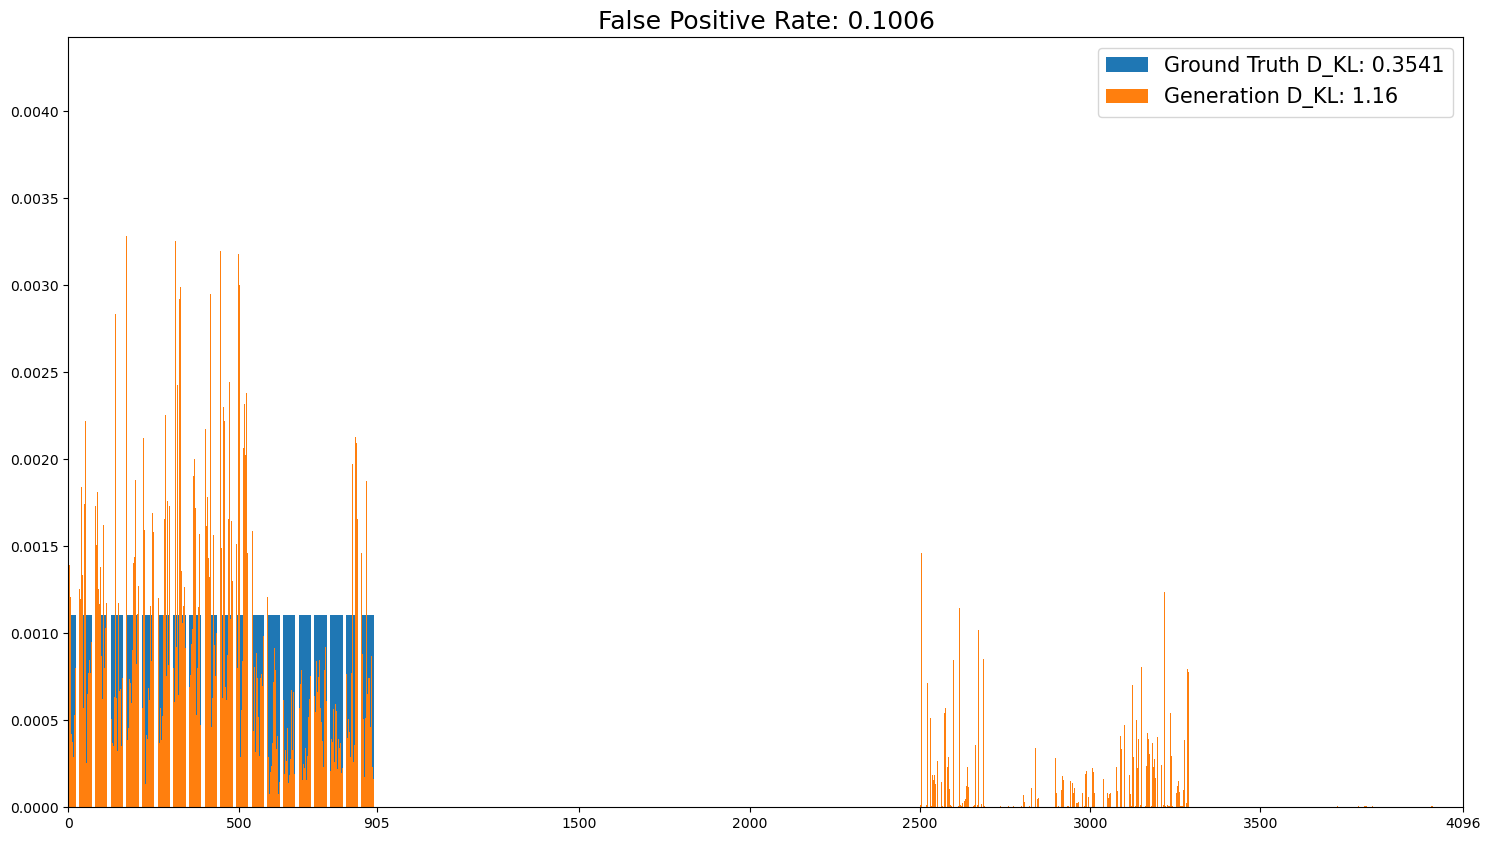

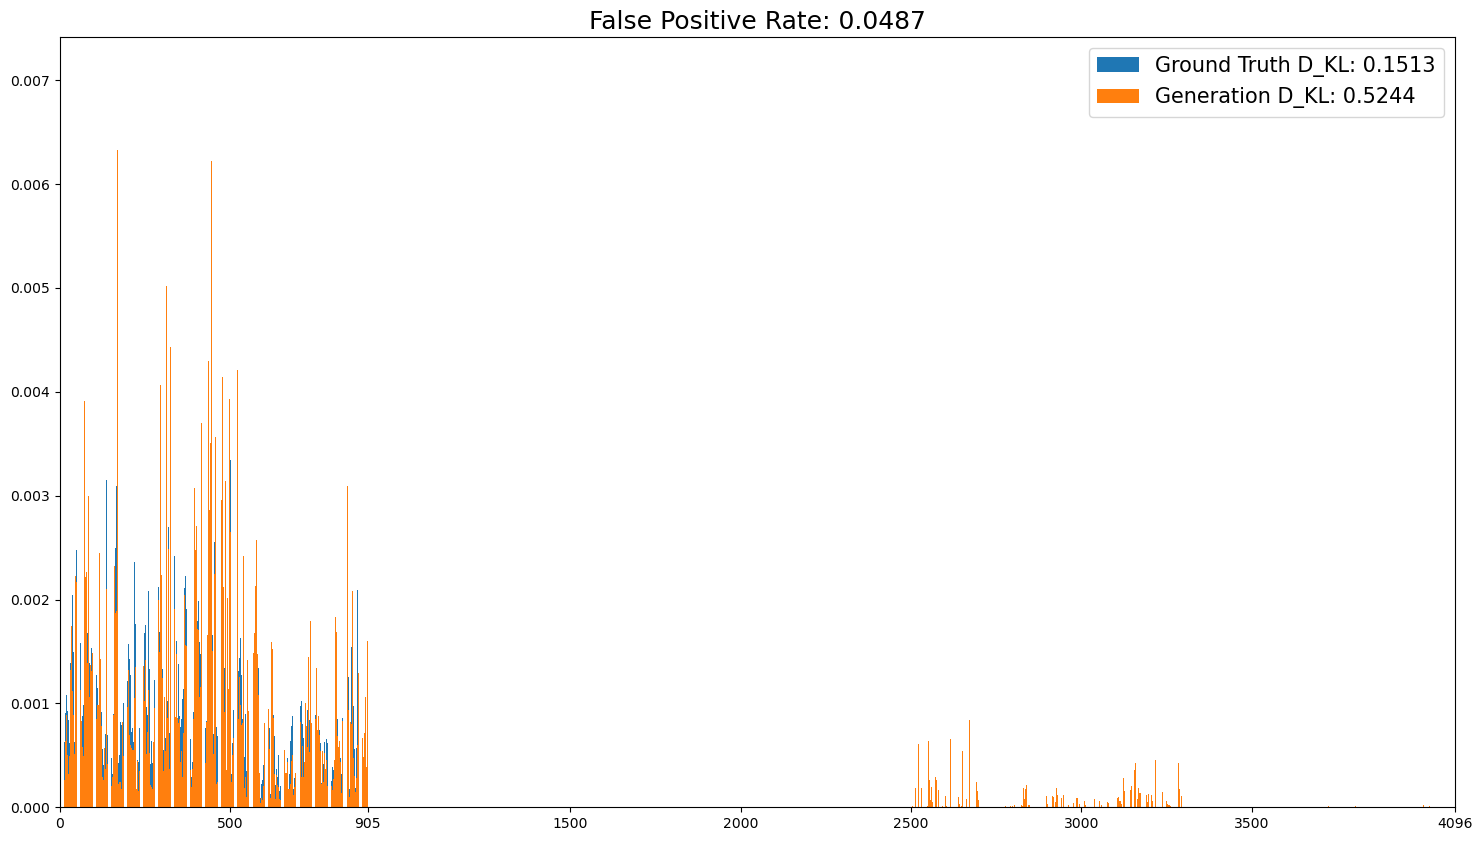

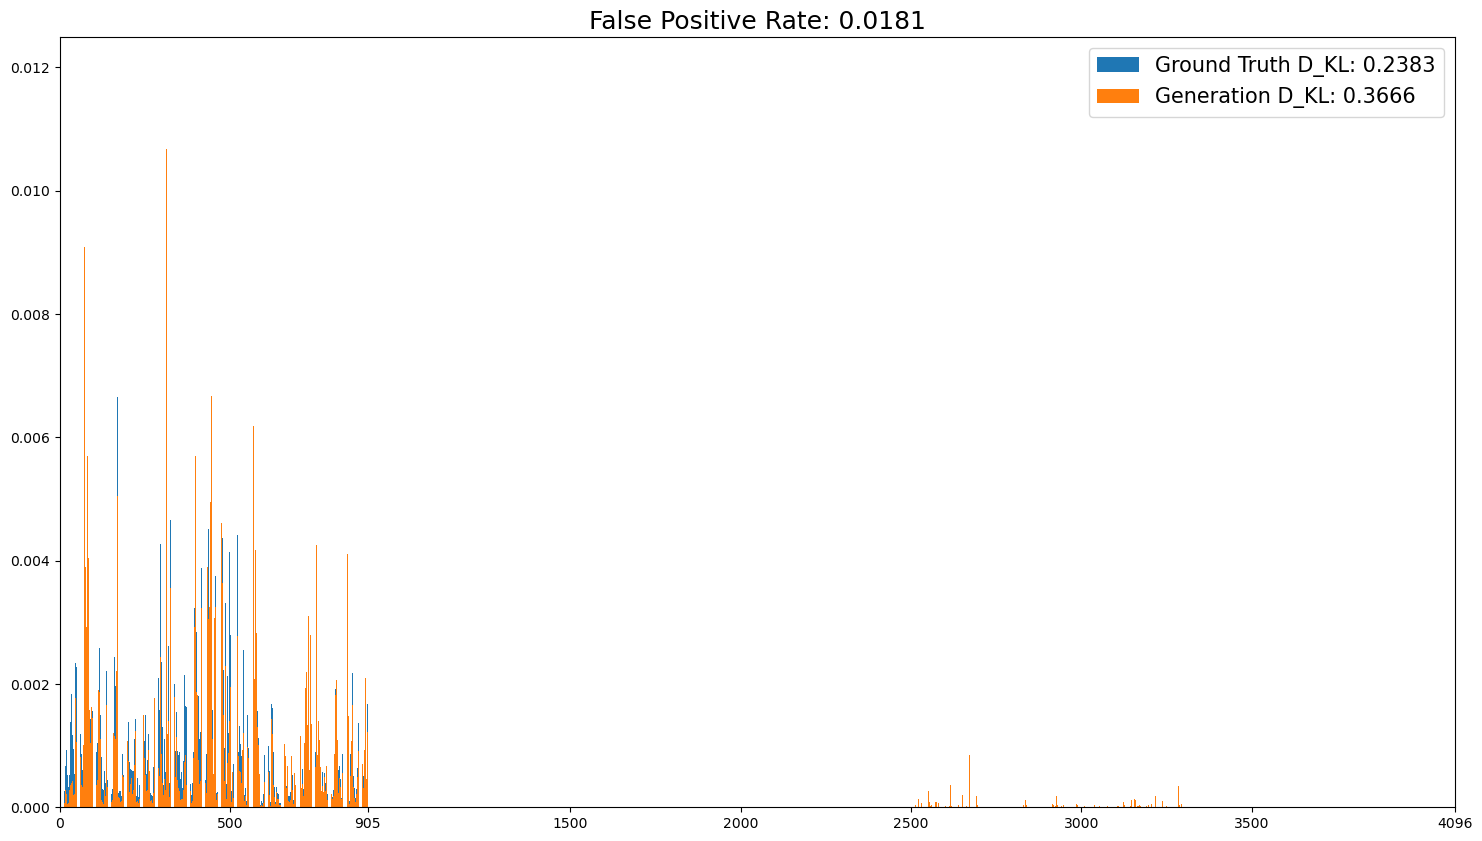

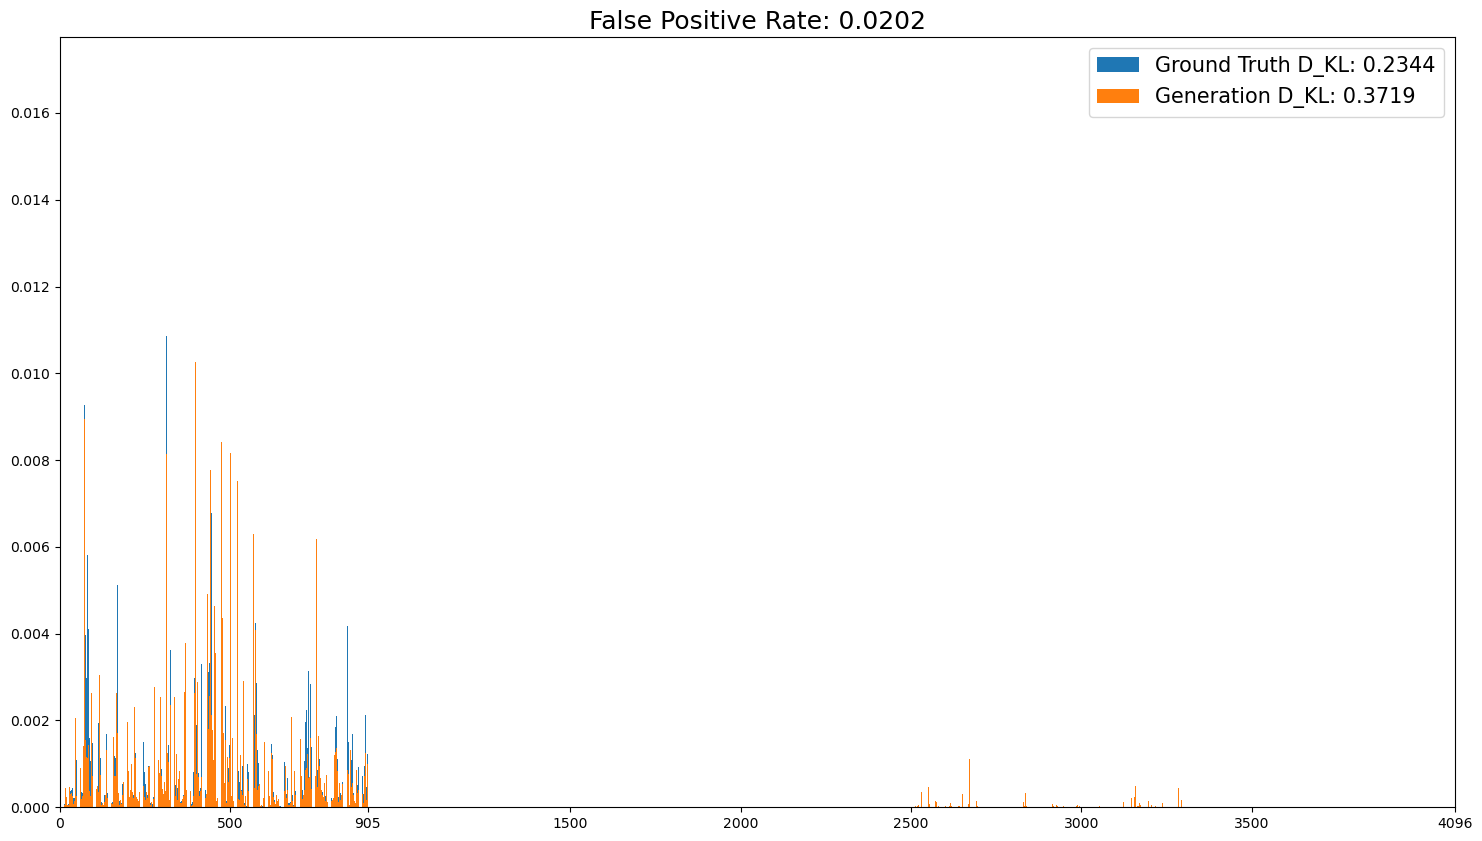

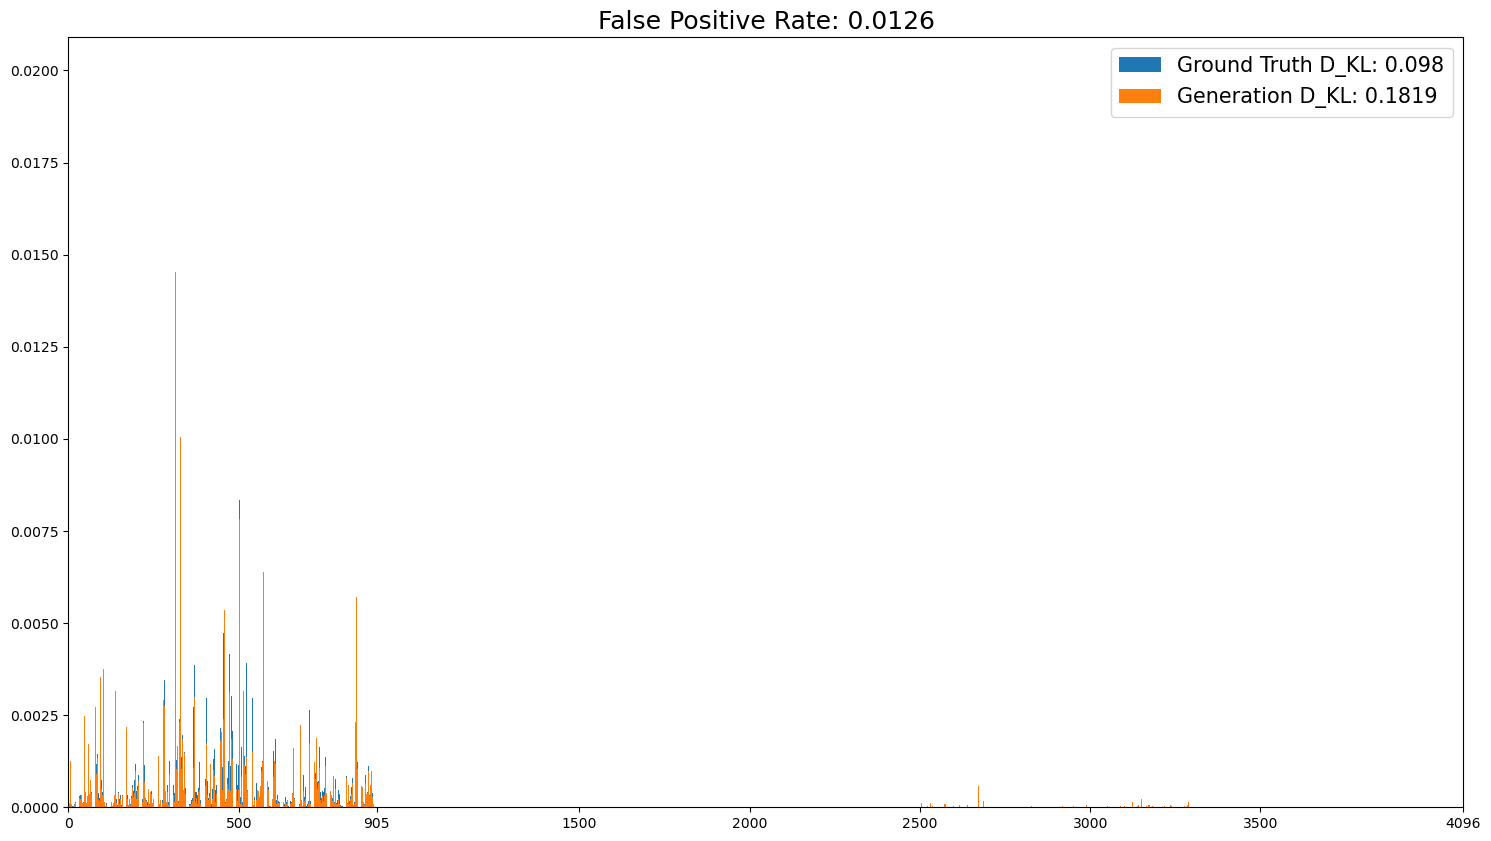

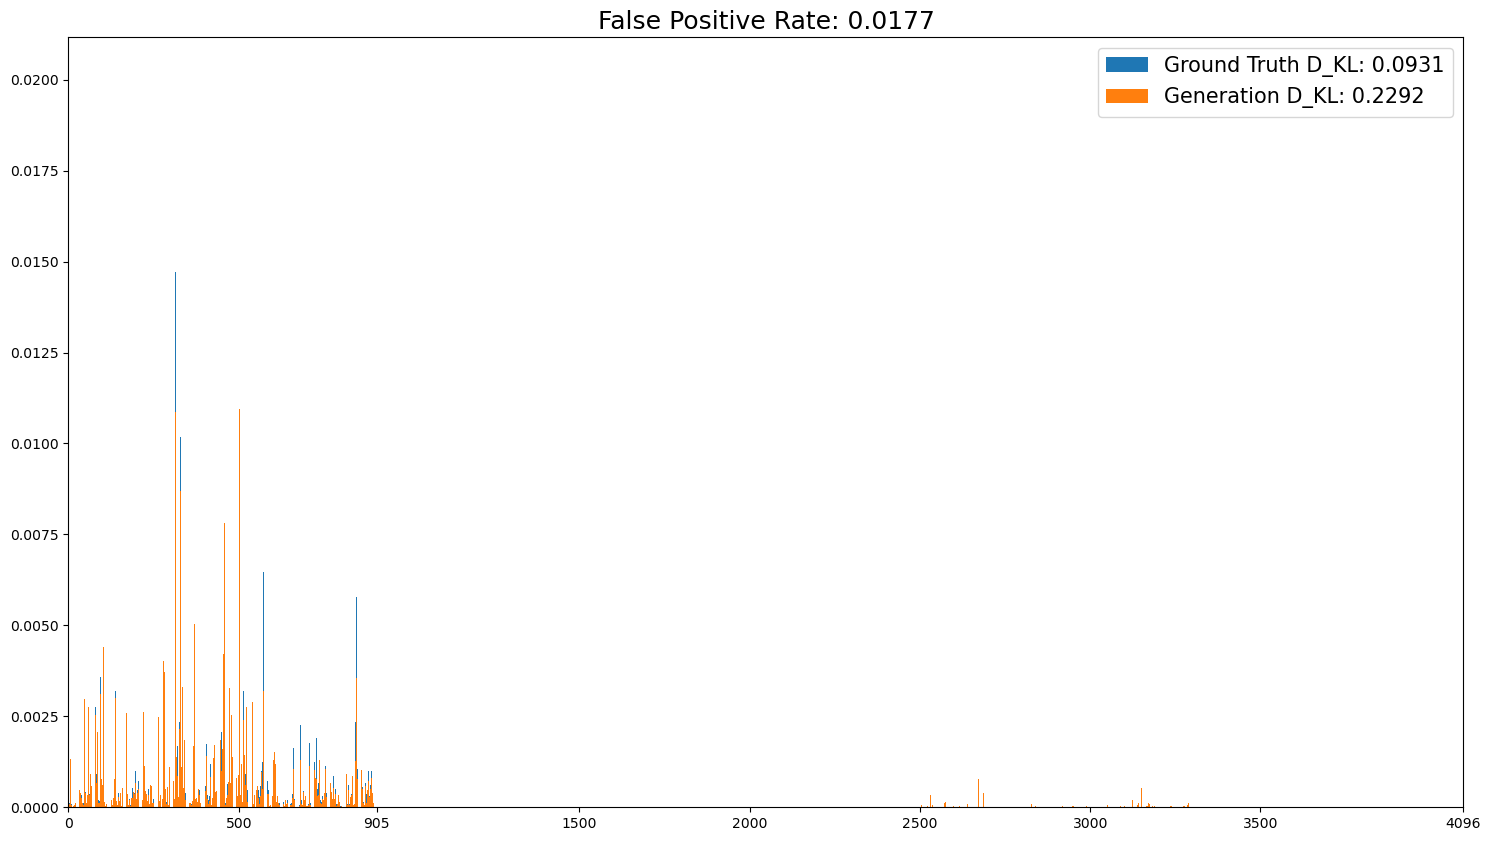

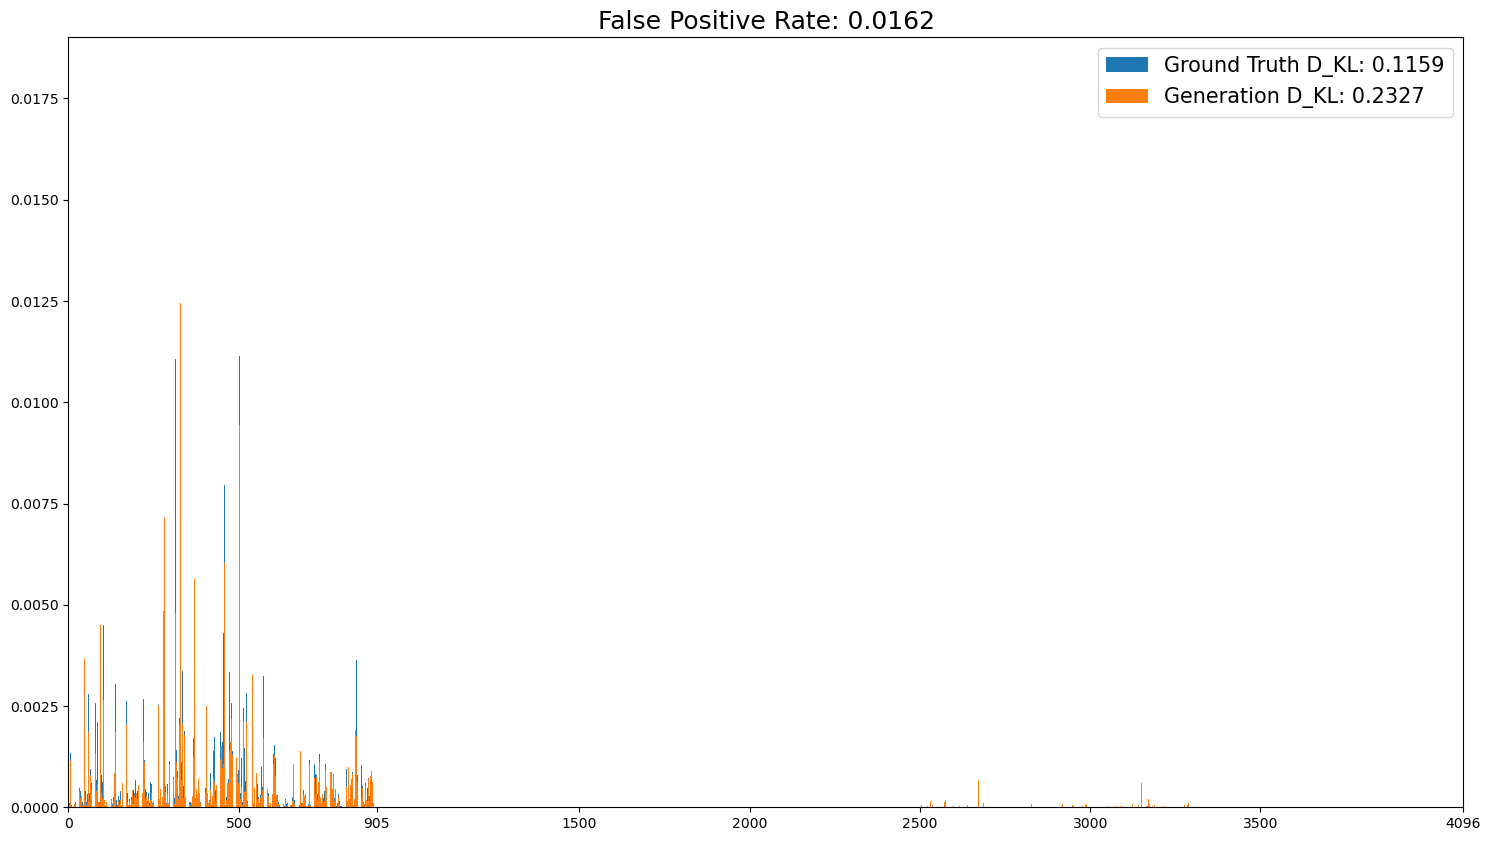

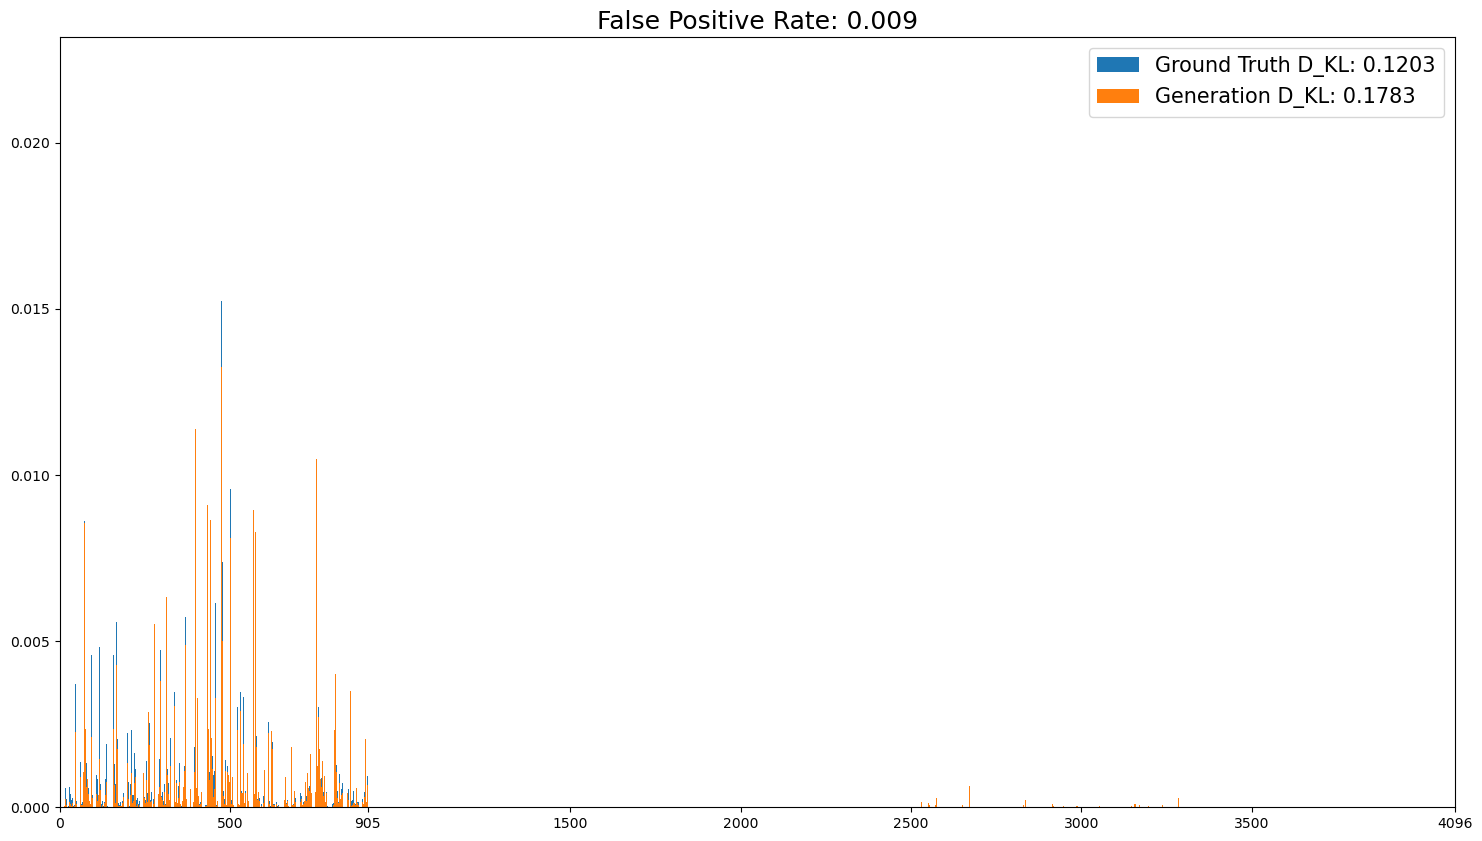

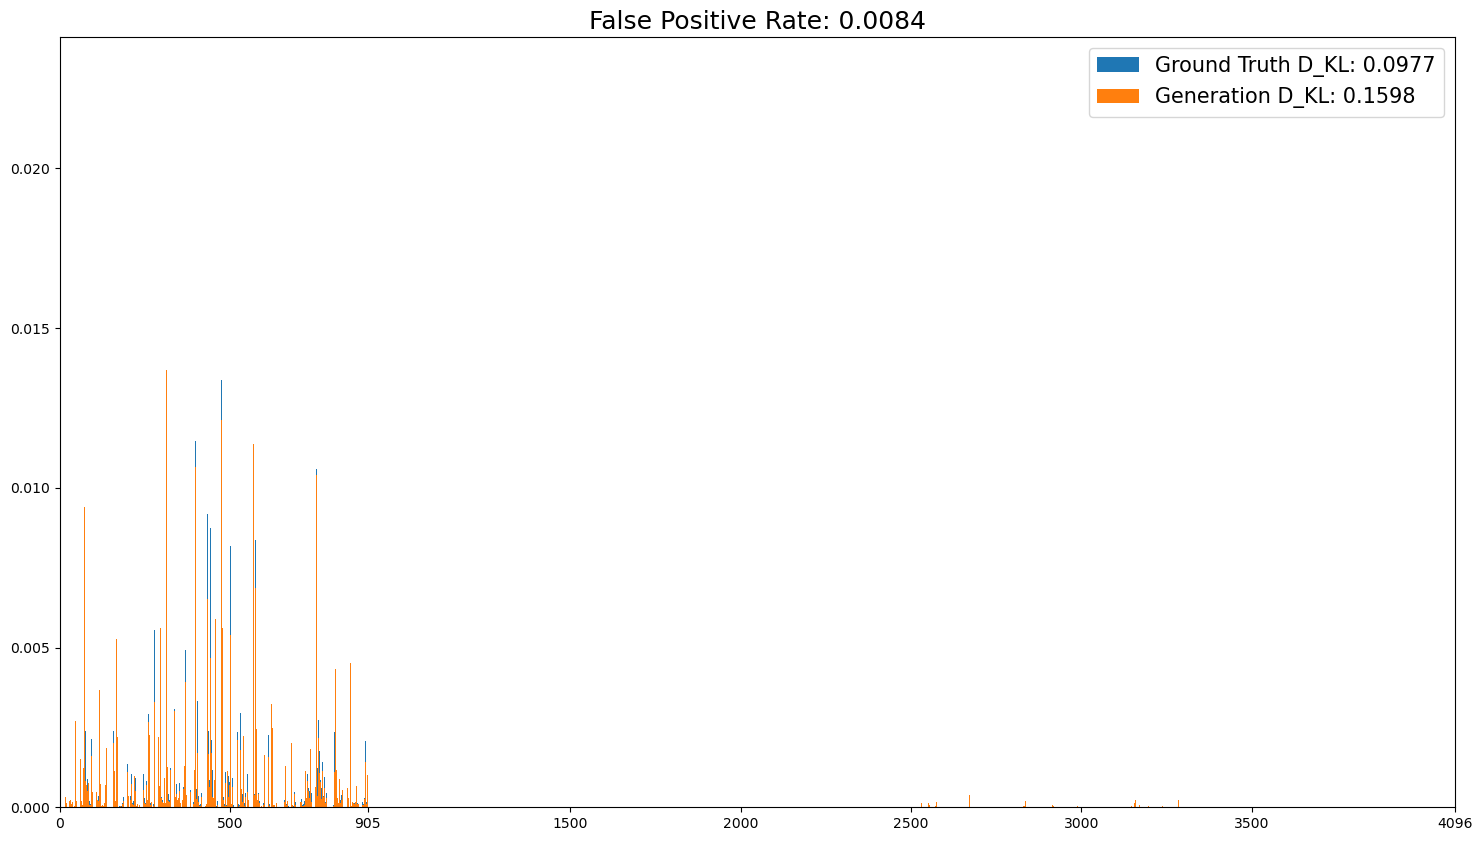

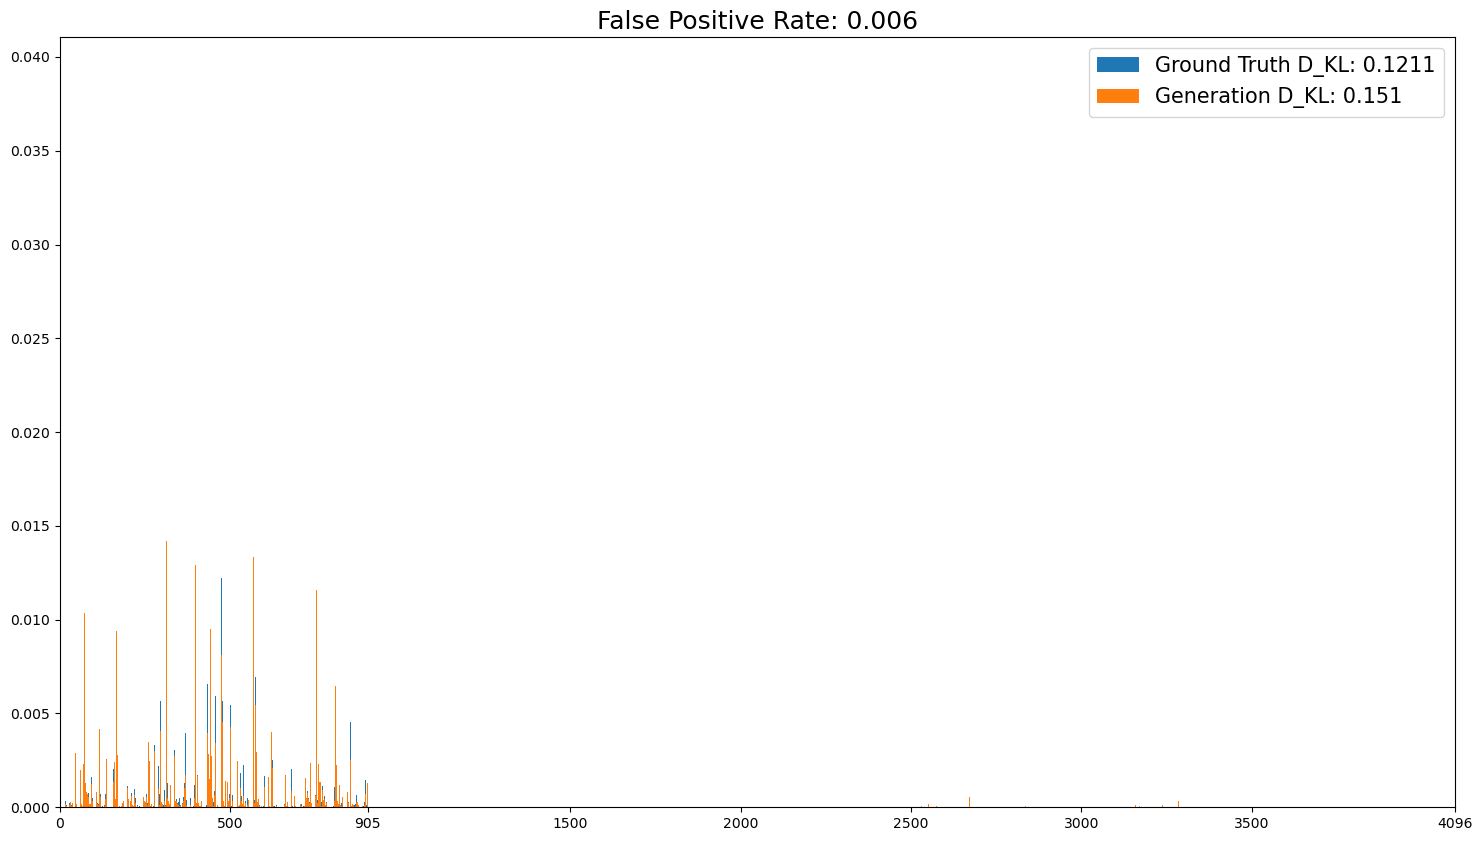

In [536]:
# Active sampling
for e in range (stage):
    HM.prob_matrix(data_dist)
    gen_dist = list(HM.Prob_cat_sleep.values())[-1][-1,:-1]

    # plot
    data_dcm = decimalize(dataset)
    values,counts = np.unique(data_dcm,return_counts=True)
    data_count = np.zeros(2**HM.n_d)
    data_count[values] = counts
    data_dist = data_count/n_data

    fig, ax = plt.subplots(figsize=(18, 10))
    D_KL_data = np.sum(data_dist*np.log(data_dist+1e-8)-data_dist*np.log(gen_dist+1e-8))    
    D_KL_gen = np.sum(gen_dist*np.log(gen_dist+1e-8)-gen_dist*np.log(data_dist+1e-8))

    ax.bar(np.arange(x_lim),data_dist[reorder],label = "Ground Truth D_KL: "+str(np.around(D_KL_data,4)))
    ax.bar(np.arange(x_lim),gen_dist[reorder],label = "Generation D_KL: "+str(np.around(D_KL_gen,4)))
    ax.set(xlim=(0, x_lim), xticks=xtick)
    percent = gen_dist[reorder][:count].sum()
    ax.set_title("False Positive Rate: "+str(np.around(1-percent,4)),fontsize=18)
    plt.legend(fontsize=15)
    fig.savefig('D:/Qualification/Helmholtz/animation/sampling/s' + str(int(e)) + '.png')

    gen_count = (gen_dist*n_well_formed*epoch + 0.5).astype(int) # multiply factor
    dataset = binarilize(np.repeat(values_d,gen_count[values_d]),HM.n_d)
    n_data = dataset.shape[1]
    
    index = np.random.permutation(n_data)
    Loss_Q_total = np.zeros(HM.n_layer)
    Loss_P_total = np.zeros(HM.n_layer)
    for i in range(n_data):
        d0 = dataset[:,index[i]:index[i]+1]
        Alpha_Q = HM.wake_sample(d0)
        Loss_P,Grad_P = HM.sleep_update(Alpha_Q)
        Alpha_P = HM.sleep_sample()
        Loss_Q,Grad_Q = HM.wake_update(Alpha_P)
        
        Loss_Q_total += Loss_Q
        Loss_P_total += Loss_P
    Loss_Q_total = Loss_Q_total/n_data
    Loss_P_total = Loss_P_total/n_data
    print('Loss_Q: '+ str(np.around(Loss_Q_total,2)), 'Loss_P: '+ str(np.around(Loss_P_total,2)), n_data)
# HM.check_learning_rate(Alpha_P,Alpha_Q)

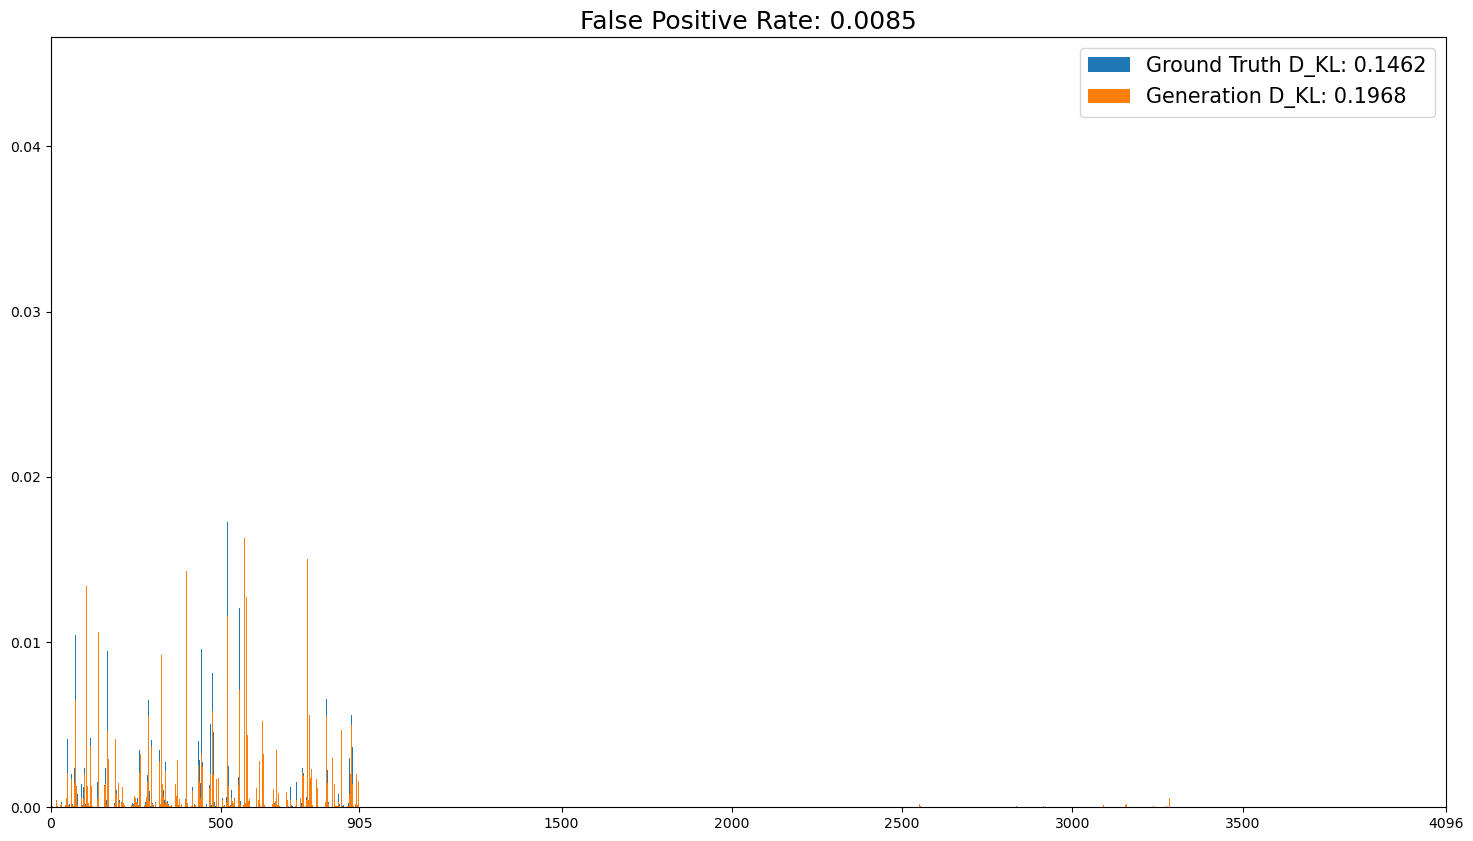

In [537]:
HM.prob_matrix(data_dist)
gen_dist = list(HM.Prob_cat_sleep.values())[-1][-1,:-1]

# plot
data_dcm = decimalize(dataset)
values,counts = np.unique(data_dcm,return_counts=True)
data_count = np.zeros(2**HM.n_d)
data_count[values] = counts
data_dist = data_count/n_data

fig, ax = plt.subplots(figsize=(18, 10))
D_KL_data = np.sum(data_dist*np.log(data_dist+1e-8)-data_dist*np.log(gen_dist+1e-8))    
D_KL_gen = np.sum(gen_dist*np.log(gen_dist+1e-8)-gen_dist*np.log(data_dist+1e-8))

ax.bar(np.arange(x_lim),data_dist[reorder],label = "Ground Truth D_KL: "+str(np.around(D_KL_data,4)))
ax.bar(np.arange(x_lim),gen_dist[reorder],label = "Generation D_KL: "+str(np.around(D_KL_gen,4)))
ax.set(xlim=(0, x_lim), xticks=xtick)
percent = gen_dist[reorder][:count].sum()
ax.set_title("False Positive Rate: "+str(np.around(1-percent,4)),fontsize=18)
plt.legend(fontsize=15)
fig.savefig('D:/Qualification/Helmholtz/animation/sampling/s91.png')

In [539]:
values.size

846

In [541]:
counts.max()

5307

### Visualization

In [2658]:
keys_s = [*HM.Prob_cat_sleep]
st_layer = 4
tg_layer = 0

In [2659]:
M = HM.Prob_cat_sleep[keys_s[HM.n_layer-1-st_layer]][:-1,:-1]
for i in range(HM.n_layer-st_layer,HM.n_layer-1-tg_layer):
    M = np.matmul(M, HM.Prob_cat_sleep[keys_s[i]][:-1,:-1])
M.shape

(8, 4096)

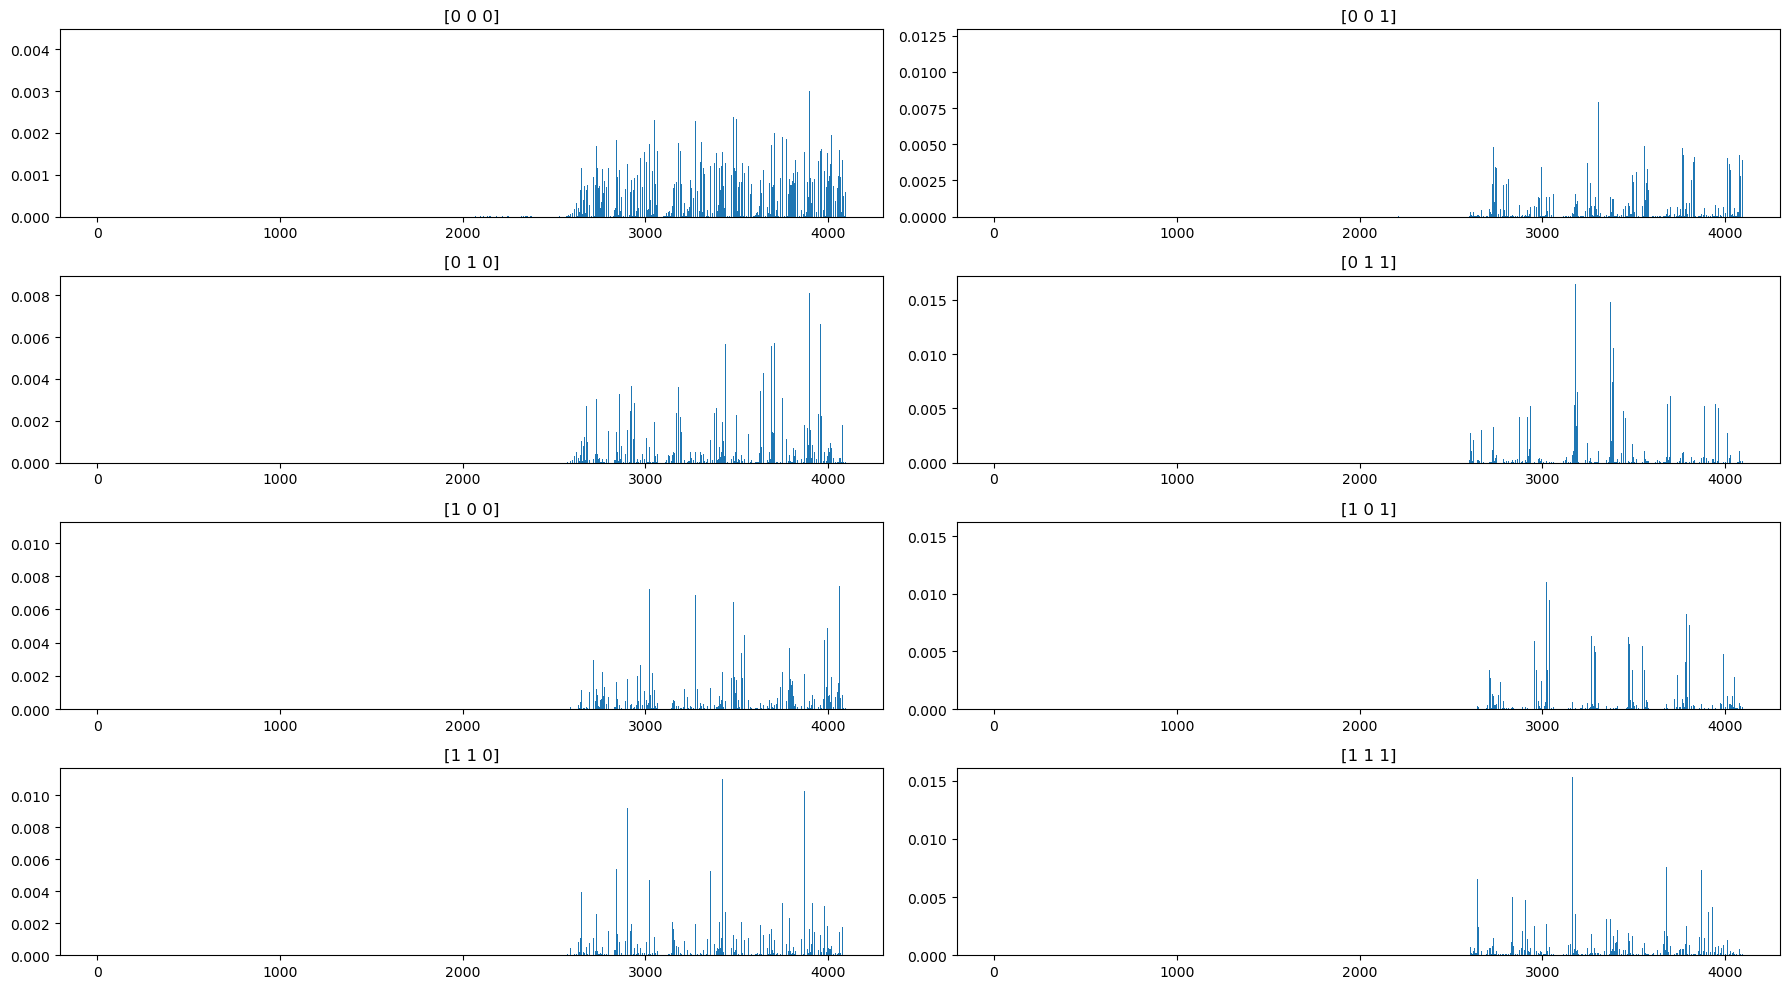

In [2660]:
n_fig = M.shape[0]
comb = binarilize(np.arange(n_fig),int(np.log2(n_fig)))
fig, ax = plt.subplots(int((n_fig+1)/2), 2,figsize=(18, 10))
for i in range(n_fig):
    ax[int(i/2),np.mod(i,2)].bar(np.arange(M.shape[1]), M[i,:]) #[reorder]
#     ax[int(i/2),np.mod(i,2)].set(xlim=(0, n_data))
    ax[int(i/2),np.mod(i,2)].set_title(str(comb[:,i]))
plt.tight_layout()
plt.show()

In [2661]:
keys_w = [*HM.Prob_cat_wake]
st_layer = 0
tg_layer = 4

In [2662]:
M = HM.Prob_cat_wake[keys_w[st_layer]][:-1,:-1]
for i in range(st_layer+1,tg_layer):
    M = np.matmul(M, HM.Prob_cat_wake[keys_w[i]][:-1,:-1])
M.shape

(4096, 8)

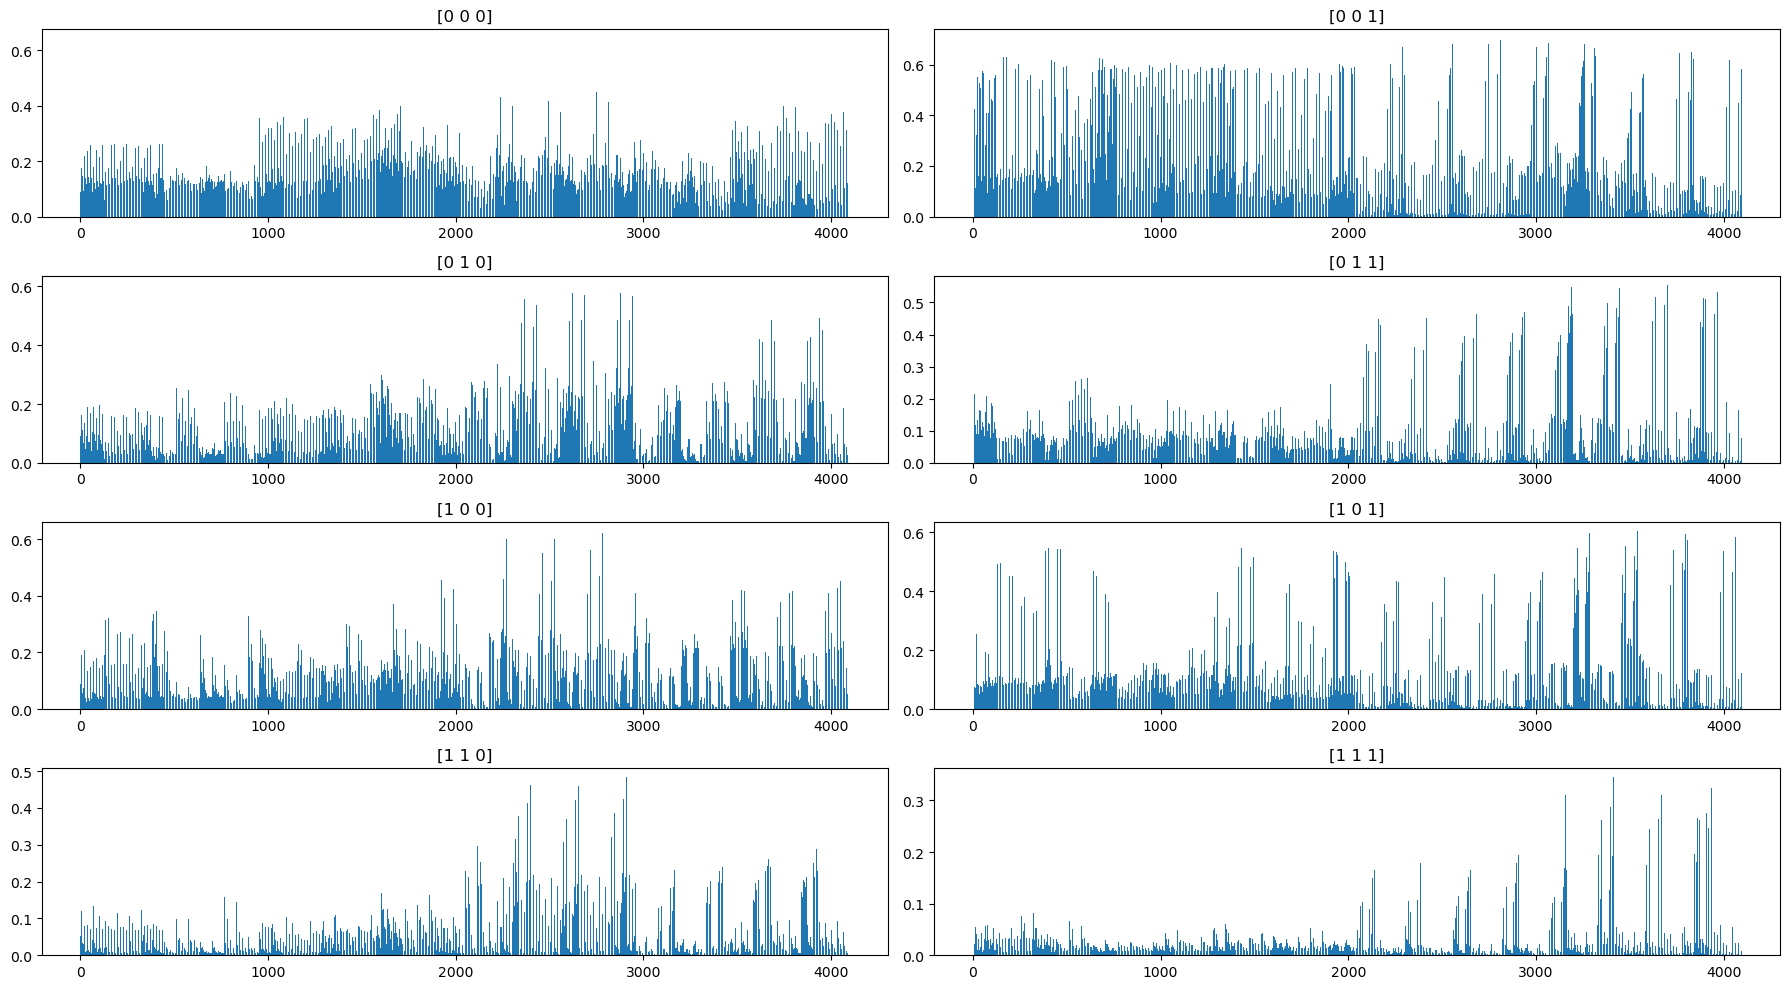

In [2663]:
M = M.T
n_fig = M.shape[0]
comb = binarilize(np.arange(n_fig),int(np.log2(n_fig)))
fig, ax = plt.subplots(int((n_fig+1)/2), 2,figsize=(18, 10))
for i in range(n_fig):
    ax[int(i/2),np.mod(i,2)].bar(np.arange(M.shape[1]), M[i,:]) #[reorder]
#     ax[int(i/2),np.mod(i,2)].set(xlim=(0, n_data))
    ax[int(i/2),np.mod(i,2)].set_title(str(comb[:,i]))
plt.tight_layout()
plt.show()

In [2664]:
keys_s = [*HM.Prob_cat_sleep]
st_layer = 4
tg_layer = 0

In [2665]:
Pb = np.copy(HM.Prob_cat_sleep[keys_s[HM.n_layer-2-st_layer]])[-1:,:-1]
n_neuron = int(np.log2(Pb.size))
comb = binarilize(np.arange(Pb.size),n_neuron)
M = np.repeat(Pb,n_neuron*2,axis=0)
for i in range(n_neuron):
    M[i*2,np.where(comb[i,:]==0)[0]] = 0  #1
    M[i*2,:] /= M[i*2,:].sum()
    M[i*2+1,np.where(comb[i,:]==1)[0]] = 0  #0
    M[i*2+1,:] /= M[i*2+1,:].sum()
M

array([[0.        , 0.        , 0.        , 0.        , 0.31891547,
        0.26261674, 0.22949004, 0.18897774],
       [0.31891547, 0.26261674, 0.22949004, 0.18897774, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.33105184, 0.27261065, 0.        ,
        0.        , 0.21735368, 0.17898383],
       [0.33105184, 0.27261065, 0.        , 0.        , 0.21735368,
        0.17898383, 0.        , 0.        ],
       [0.        , 0.35104918, 0.        , 0.25261331, 0.        ,
        0.23048303, 0.        , 0.16585448],
       [0.35104918, 0.        , 0.25261331, 0.        , 0.23048303,
        0.        , 0.16585448, 0.        ]])

In [2666]:
for i in range(HM.n_layer-1-st_layer,HM.n_layer-1-tg_layer):
    M = np.matmul(M, HM.Prob_cat_sleep[keys_s[i]][:-1,:-1])
M.shape

(6, 4096)

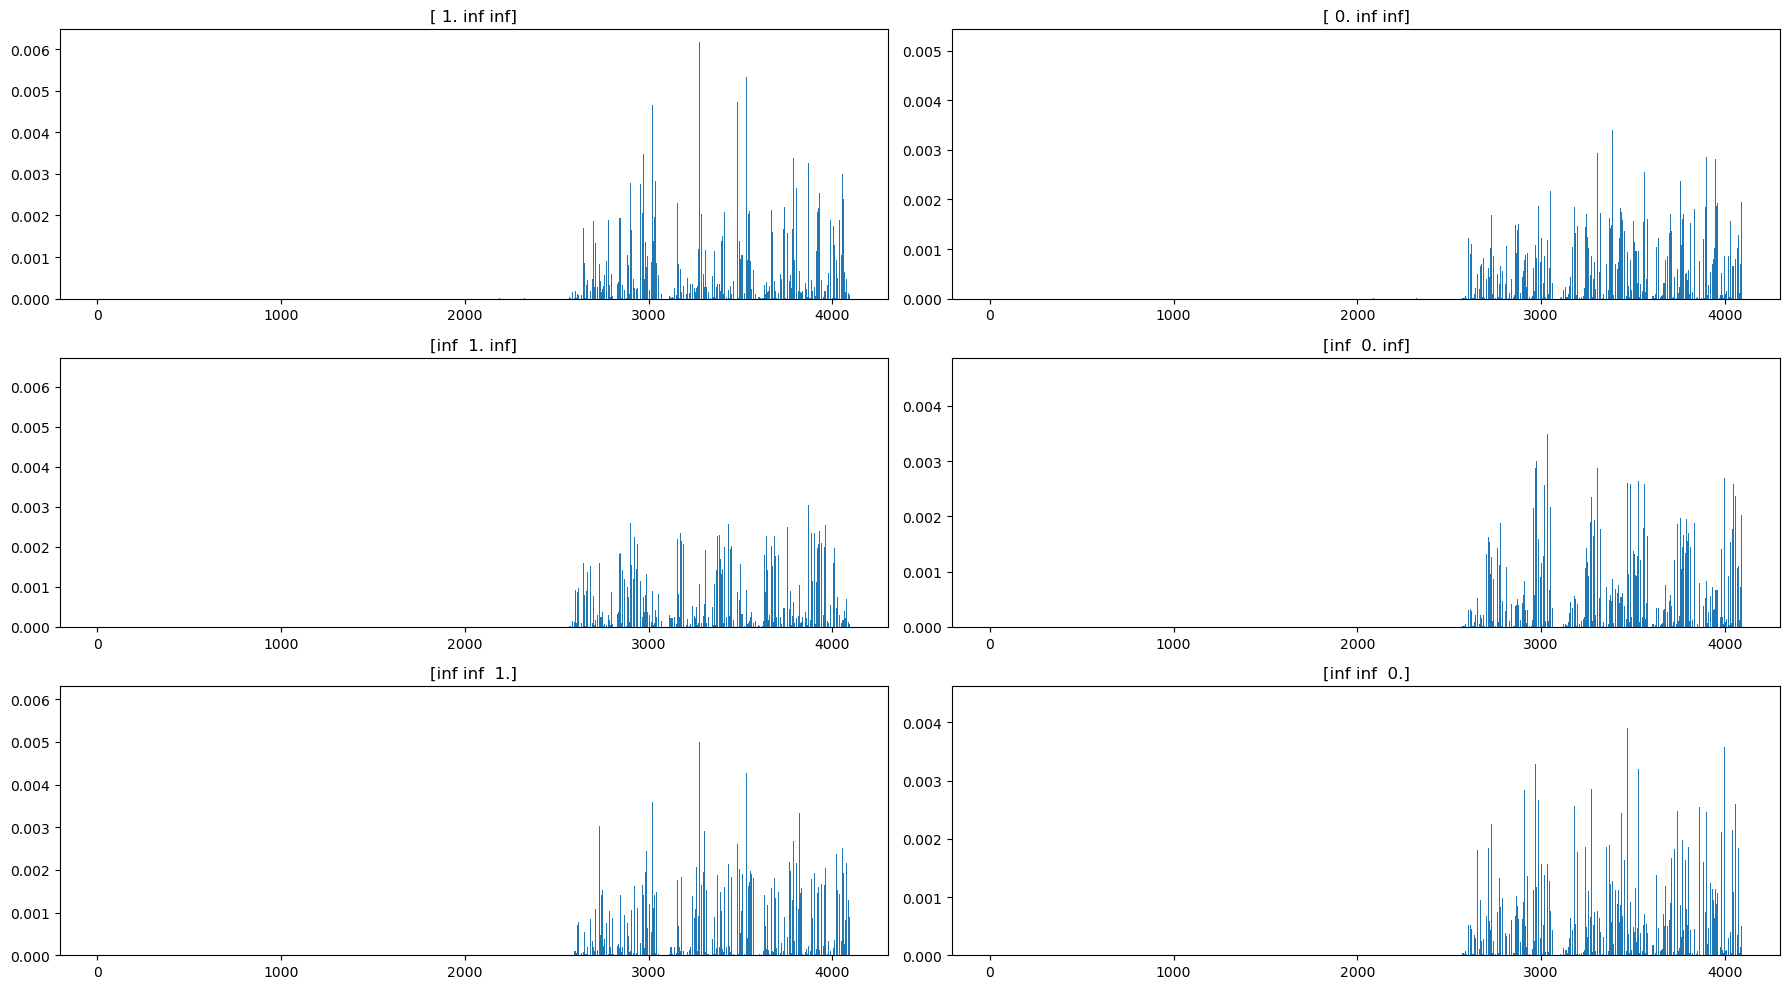

In [2667]:
n_fig = M.shape[0]
fig, ax = plt.subplots(int((n_fig+1)/2), 2,figsize=(18, 10))
for i in range(n_fig):
    ax[int(i/2),np.mod(i,2)].bar(np.arange(M.shape[1]), M[i,:]) #[reorder]
#     ax[int(i/2),np.mod(i,2)].set(xlim=(0, n_data))
    title = np.zeros(n_neuron)
    title.fill(np.inf)
    title[int(i/2)] = np.mod(i+1,2)
    ax[int(i/2),np.mod(i,2)].set_title(str(title))
plt.tight_layout()
plt.show()

### Auralization

In [2668]:
keys_s = [*HM.Prob_cat_sleep]
st_layer = 3
tg_layer = 0

Pb = np.copy(HM.Prob_cat_sleep[keys_s[HM.n_layer-2-st_layer]])[-1:,:-1]
n_neuron = int(np.log2(Pb.size))
comb = binarilize(np.arange(Pb.size),n_neuron)
M = np.repeat(Pb,n_neuron,axis=0)
for i in range(n_neuron):
    M[i,np.where(comb[i,:]==0)[0]] = 0  #1
    M[i,:] /= M[i,:].sum()
        
for i in range(HM.n_layer-1-st_layer,HM.n_layer-1-tg_layer):
    M = np.matmul(M, HM.Prob_cat_sleep[keys_s[i]][:-1,:-1])
M_instr = M

In [2669]:
M_instr.shape

(6, 4096)

In [2670]:
instr_dist = np.zeros((M_instr.shape[0],HM.n_d))
for i in range(HM.n_d):
    instr_dist[:,i] = M_instr[:,np.where(entire_set[i,:]==1)[0]].sum(axis=1)
instr_dist

array([[0.99997127, 0.68985218, 0.68560024, 0.61447895, 0.50416576,
        0.56079859, 0.51132091, 0.98089481, 0.62315651, 0.63577723,
        0.6040028 , 0.45237339],
       [0.99998016, 0.71647878, 0.60864357, 0.54108462, 0.50980858,
        0.98232379, 0.52274767, 0.5269385 , 0.63812812, 0.66398315,
        0.61229562, 0.52364563],
       [0.99997895, 0.68382784, 0.64132359, 0.54466988, 0.98150852,
        0.57100184, 0.4821633 , 0.56115956, 0.66440318, 0.63067046,
        0.60302353, 0.56731262],
       [0.99994973, 0.6901618 , 0.67947157, 0.60109581, 0.53966697,
        0.57148891, 0.51322949, 0.5123372 , 0.72803634, 0.63992212,
        0.78168153, 0.07069485],
       [0.99997831, 0.70805427, 0.64062264, 0.57776101, 0.57388975,
        0.56787467, 0.53802881, 0.5379302 , 0.63803063, 0.98069857,
        0.51013028, 0.55127641],
       [0.99997422, 0.73756775, 0.62232007, 0.52090258, 0.49458709,
        0.56416298, 0.98242438, 0.52967085, 0.66119395, 0.60739257,
        0.57818889,

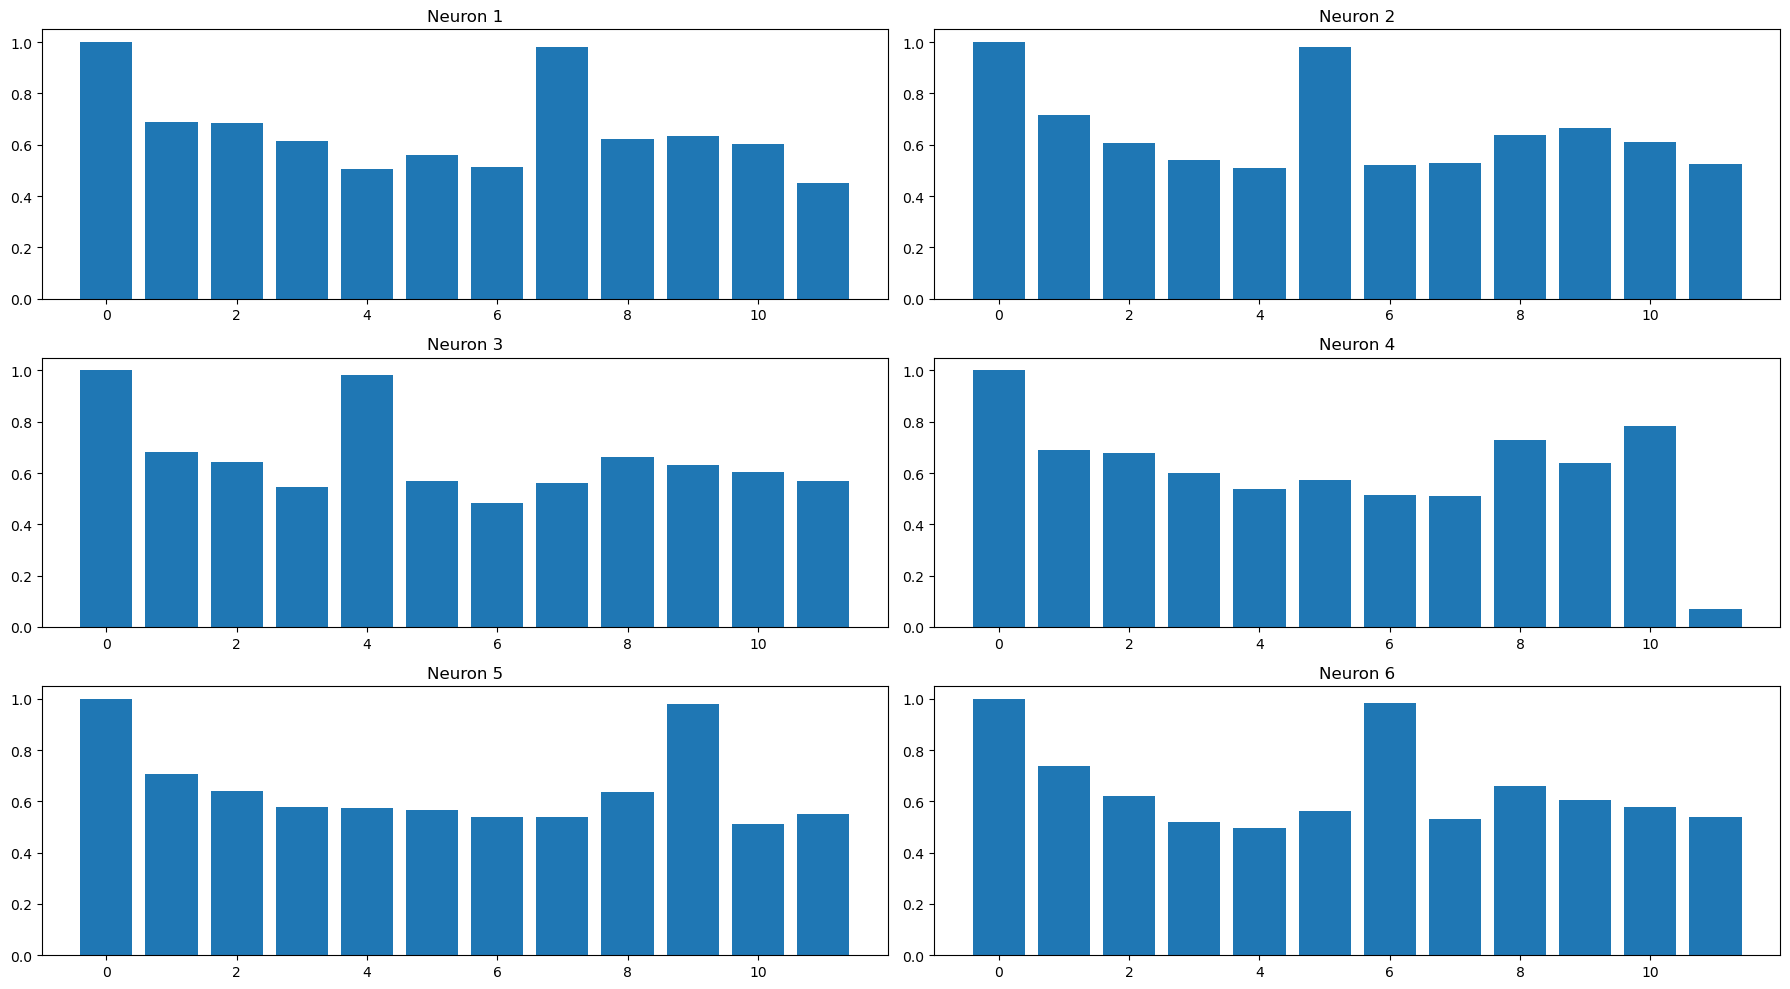

In [2671]:
n_fig = instr_dist.shape[0]
fig, ax = plt.subplots(int((n_fig+1)/2), 2,figsize=(18, 10))
for i in range(n_fig):
    ax[int(i/2),np.mod(i,2)].bar(np.arange(instr_dist.shape[1]), instr_dist[i,:])
    ax[int(i/2),np.mod(i,2)].set_title('Neuron '+str(i+1))
plt.tight_layout()
plt.show()

In [1146]:
import librosa
from IPython.display import Audio
import pyaudio
import wave
import sys
import os
from pathlib import Path
import time
import threading
import logging

In [1147]:
txt_folder = Path('Instruments').rglob('*.wav')
Instruments = []
for x in txt_folder:
    basename = os.path.basename(x)
    filename = os.path.splitext(basename)[0]
    Instruments.append(filename)
instruments_sound = {}
for i in range(len(Instruments)):
    instruments_sound[Instruments[i]],fs = librosa.load('Instruments/'+Instruments[i]+'.wav')

In [2048]:
instruments_sound

{'bass': array([ 4.3169763e-03,  1.5512958e-02,  4.2102553e-02, ...,
         2.7313945e-08, -3.1166564e-08,  3.3571268e-08], dtype=float32),
 'clap': array([-5.2706543e-02,  6.8760648e-02, -1.4342493e-01, ...,
         8.6916843e-06, -2.4170677e-06,  9.0632864e-07], dtype=float32),
 'hihat closed': array([ 8.7055489e-02,  3.4345269e-01, -4.2524356e-01, ...,
         5.6425459e-05,  1.7882790e-05, -3.8322993e-05], dtype=float32),
 'hihat open': array([ 9.8636545e-02,  2.8145188e-01, -1.9611624e-01, ...,
        -7.8135054e-07,  1.1714292e-07,  1.0206713e-07], dtype=float32),
 'kick': array([-0.00218478, -0.00930428, -0.01938734, ..., -0.00053879,
        -0.00056686, -0.00048317], dtype=float32),
 'snare': array([ 7.6284137e-04,  9.2353951e-03,  7.4334239e-04, ...,
        -2.6067326e-05, -1.1731618e-05,  0.0000000e+00], dtype=float32)}

In [1148]:
def y_init(n_d,BPM,fs):
    BS = 60/BPM # beat length in seconds
    len_gen = int(BS * fs * n_d + 0.5)
    y = np.zeros((len_gen*2,))
    return y,len_gen

In [1149]:
def synthesis(instr_pattern,instruments_sound,y,deviation=600):
    """
    Arguments:
    instr_pattern -- The on/off pattern of each instruments, numpy array of shape (n_instr,n_d), n_d is data length, default 12
    instruments_sound -- Python disctionary with key: instrument name & value: instrument wave form in floating number farmat [-1,1]
    y -- residual of previous generation for adding on, numpy array of shape (int(60/BPM * fs * n_d + 0.5)*2, )
    deviation -- deviation from beat grid in samples, a number likely 500-1000
    
    Returns:
    y -- generated audio in floating number farmat [-1,1], numpy array of shape (int(60/BPM * fs * n_d + 0.5)*2, )
    y_byte -- byte format of first half of y, namely y[:len(y)/2]
    """
    n_instr = instr_pattern.shape[0]
    n_d = instr_pattern.shape[1]
    y_beat = int(len(y)/(2*n_d) + 0.5)
    keys = [*instruments_sound]
    
    for i in range(n_instr):
        pt = instr_pattern[i,:]
        count = np.where(pt==1)[0].size
        y_instr = instruments_sound[keys[i]]
        if count > 0:
            onset = np.where(pt==1)[0]*y_beat + np.random.randn(count)*deviation
            onset = np.clip(onset,0,None).astype(int)
            for j in range(count):
                y[onset[j]:onset[j]+len(y_instr)] += y_instr*np.random.rand()
    
    y_max = np.max(np.abs(y))
    if y_max > 1:
        y = y/y_max*0.98
    
    # Int16 -- (-32,768 to +32,767)    
    y_int16 = (y[:int(len(y)/2)] * 32768 - 0.5).astype('int16')
    y_byte = y_int16.tobytes()
    
    return y, y_byte

In [1150]:
BPM = 160
deviation=600

In [1151]:
instr_pattern = HM.sleep_sample_batch(n_sample=6,norm_par=False)['z0'].T
instr_pattern

array([[0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1],
       [0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0],
       [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1],
       [0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1]])

In [1152]:
y,len_gen = y_init(HM.n_d,BPM,fs)
instr_pattern = HM.sleep_sample_batch(n_sample=6,norm_par=False)['z0'].T
y_out, y_byte = synthesis(instr_pattern,instruments_sound,y,deviation)
y.fill(0)
y[:len_gen] = y_out[len_gen:]
y_play = y_out[:len_gen]

In [1153]:
instr_pattern = HM.sleep_sample_batch(n_sample=6,norm_par=False)['z0'].T
y_out, y_byte_next = synthesis(instr_pattern,instruments_sound,y,deviation)
y_play = np.append(y_play,y_out)

In [1154]:
Audio(data=y_play, rate=fs)

In [2672]:
def streaming(threadname):
    global flag
    pya = pyaudio.PyAudio()
    stream = pya.open(format=pya.get_format_from_width(width=2), channels=1, rate=fs, output=True)
    logging.warning("Streaming start")
    while True:
        stream.write(y_byte)
        flag = 1
        event.set()
        if signal == 1:
            break
        
        stream.write(y_byte_next)
        flag = 2
        event.set()
        if signal == 2:
            break
    
    stream.stop_stream()
    stream.close()
    pya.terminate()
    logging.warning("Streaming thread finish")

In [2673]:
def control(threadname):
    global y_out,y_byte, y_byte_next, signal #, y_byte, y_byte_next, y_out
    while stop == 'n':
        instr_pattern = HM.sleep_sample_batch(n_sample=6,norm_par=False)['z0'].T
        y_out, y_buffer = synthesis(instr_pattern,instruments_sound,y,deviation=600)
        y.fill(0)
        y[:len_gen] = y_out[len_gen:]
        
        event.wait()
        if flag == 1:
            y_byte = y_buffer
            logging.warning("write y_byte")
        elif flag == 2:
            y_byte_next = y_buffer
            logging.warning("write y_byte_next")
        event.clear()
        
    # after stop    
    y_int16 = (y[:int(len(y)/2)] * 32768 - 0.5).astype('int16')
    y_buffer = y_int16.tobytes()

    event.wait()
    if flag == 1:
        y_byte = y_buffer
        signal = 1
        logging.warning("write y_byte last")
    elif flag == 2:
        y_byte_next = y_buffer
        signal = 2
        logging.warning("write y_byte_next last")
    event.clear()
    logging.warning("Control thread finish")

In [2674]:
def user_input(threadname):
    global stop
    stop = input("stop?(y)")
    logging.warning("User input thread finish")

In [2675]:
# Threading
event = threading.Event()
stop = 'n'
signal = 0
thread1 = threading.Thread(target=streaming, args=("Thread-1", ) )
thread2 = threading.Thread(target=control, args=("Thread-2", ) )
thread3 = threading.Thread(target=user_input, args=("Thread-3", ) )

thread1.start()
thread2.start()
thread3.start()
thread1.join()
thread2.join()
thread3.join()

stop?(y)y
